In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pyfits as pf
import numpy as np
import cosmolopy.distance as cd
from astropy.stats import median_absolute_deviation
%pylab inline 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Populating the interactive namespace from numpy and matplotlib


In [2]:
sample = h5py.File("red_photometric_sample_v2ij_auto.h5" , "r")
#lrg_dense = h5py.File("LRG_lmin_0.5_nbar_0.005_auto_v3.h5" , "r")
#lrg_lum = h5py.File("LRG_lmin_1.0_nbar_0.0002_auto_v5.h5" , "r")
lrg_dense = h5py.File("LRG_lmin_0.5_nbar_0.001_auto_vjune.h5" , "r")
lrg_lum = h5py.File("LRG_lmin_1.0_nbar_0.0002_auto_vjune.h5" , "r")
reduced_kids = h5py.File("reduced_kids_auto.h5" , "r")
bright_sample = pf.open("KiDS_DR3_GAMA-like_rAUTOless20.3_NOMASKING_forMV.fits")

In [3]:
ID_kids = reduced_kids['ID'][:]#[:28158450]
mi = reduced_kids['mi'][:]#[:28158450]
z_ann = reduced_kids['redshift'][:]#[:28158450]
colors = reduced_kids['colors'][:]#[:28158450]
color_errs = reduced_kids['color_errs'][:]#[:28158450]
z_bpz = reduced_kids['BPZ'][:]#[:28158450]
RA = reduced_kids['RA'][:]#[:28158450]
DEC = reduced_kids['DEC'][:]#[:28158450]

In [4]:
bright_z_ann = bright_sample[1].data['zphot_ANNz2']
bright_z_ID = bright_sample[1].data['ID']

In [5]:
spec_kids = h5py.File("reduced_speckids_auto.h5" , 'r')

In [6]:
def dflens():
    fname = 'KiDS_DR3_x_2dFLenS.txt'
    with open(fname) as f:
        
         lines = f.readlines()
            
    ID_2df , z_2df , mi_2df , qual_2df = [] , [] , [] , []
    for i in range(1,len(lines)):
        
     if (lines[i].split()[:200][-26]!='""'):  
        ID_2df.append('KIDS '+lines[i].split()[:200][1].replace('"',''))
        z_2df.append(lines[i].split()[:200][-3])
        mi_2df.append(lines[i].split()[:200][-50].replace('"',''))
        qual_2df.append(lines[i].split()[:200][-2])
    #print z_2df
    #print mi_2df
    z_2df = np.array(z_2df ,dtype = float)
    ID_2df = np.array(ID_2df)
    mi_2df = np.array(mi_2df)
    qual_2df = np.array(qual_2df, dtype = float)
    
    mask = (mi_2df!='')&(mi_2df!='nan')&(qual_2df>3)#&(mi_2df<22)
    
    ID_2df = ID_2df[mask]
    z_2df = z_2df[mask]
    qual_2df = qual_2df[mask]
    mi_2df = mi_2df[mask]
    
    mi_2df = np.array(mi_2df, dtype= float)
     
    return ID_2df , z_2df, mi_2df, qual_2df

ID_2df , z_2df , mi_2df , qual_2df = dflens()

In [7]:
print ID_2df
print z_2df

['KIDS J000054.56-313746.47' 'KIDS J000051.98-313736.15'
 'KIDS J000043.52-313654.11' ... 'KIDS J032908.67-310045.89'
 'KIDS J032753.89-305146.62' 'KIDS J032728.80-304843.08']
[0.12619 0.11539 0.11527 ... 0.1773  0.19591 0.23223]


In [8]:
ID_2df , z_2df , mi_2df , qual_2df = ID_2df , z_2df , mi_2df , qual_2df

In [9]:
ID_spec = spec_kids["ID"][:]
z_spec = spec_kids["redshift"][:]
mi_spec = spec_kids["mi"][:]
RA_spec = spec_kids["RA"][:]
DEC_spec = spec_kids["DEC"][:]

mask = np.where(np.in1d(ID_2df , ID_spec)==False)[0]
ID_2df, z_2df, mi_2df = ID_2df[mask], z_2df[mask], mi_2df[mask]

In [10]:
colors_spec = spec_kids["colors"][:]

Text(0.5,0,u'$z$')

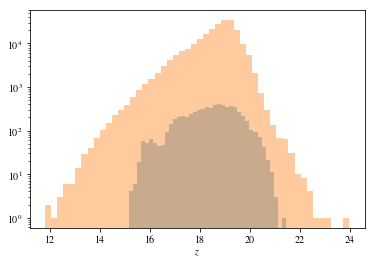

In [11]:
sns.distplot(mi_2df , kde = False, norm_hist=False)
sns.distplot(mi_spec , kde = False, norm_hist=False)
plt.yscale("log")
plt.xlabel("$z$")

In [12]:
ID_specall = np.hstack([ID_spec, ID_2df])
z_specall = np.hstack([z_spec, z_2df])
mi_specall = np.hstack([mi_spec, mi_2df])

#ID_specall = ID_spec
#z_specall = z_spec
#mi_specall = mi_spec

#ID_specall = ID_2df
#z_specall = z_2df
#mi_specall = mi_2df


ID_specall , spec_index = np.unique(ID_specall , return_index = True)
z_specall = z_specall[spec_index]
mi_specall = mi_specall[spec_index]

In [13]:
z_dense = lrg_dense["redshift"][:]
ID_dense = lrg_dense["ID"][:]
mi_dense = lrg_dense["mi"][:]
colors_dense = lrg_dense["colors"][:]

z_lum = lrg_lum["redshift"][:]
ID_lum = lrg_lum["ID"][:]
mi_lum = lrg_lum["mi"][:]
colors_lum = lrg_lum["colors"][:]

['KIDS J000000.37-312726.61' 'KIDS J000000.42-325530.01'
 'KIDS J000000.81-325414.70' ... 'KIDS J235959.34-325618.19'
 'KIDS J235959.37-325611.89' 'KIDS J235959.67-333022.56']
[20.479742 20.283745 20.297638 ... 20.012848 19.99771  20.042599]


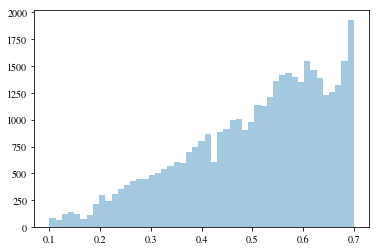

In [14]:
print ID_dense
print mi_lum
sns.distplot(z_lum , kde = False)

In [15]:
def vc(z):
    '''
    dv/dz to impose uniformity
    in redshift
    '''
    cosmo = {'omega_M_0':0.3, 'omega_lambda_0':0.7, 'omega_k_0':0.0, 'h':1.0}

    return cd.comoving_volume(z,**cosmo)

In [28]:
def red_spec_dist_dense():
    
    lrg_spec_mask = np.where((np.in1d(ID_specall , ID_dense)==True))#&(z_specall>0.1)&(z_specall<0.7))
    
    plt.figure(figsize=(10,10))
    
    sns.distplot(z_dense , kde = False , bins = 50 , hist_kws={"histtype": "step", "linewidth": 6, 
                                                               "alpha" : 1.0, "label":"dense sample"})
    sns.distplot(z_specall[lrg_spec_mask], 
                 kde = False , bins = 50,hist_kws={"histtype": "step", "linewidth": 6, 
                                                  "alpha" : 1.0, "label":"dense sample with specz"})
    
    ztest = np.linspace(0.1, 0.7 , 50)
    bins = .5*(ztest[1:]+ztest[:-1])
    dvbin = vc(ztest[1:]) - vc(ztest[:-1])
    dvbin = dvbin * 360.3 / (41252.96)
    nbar = 0.001
    plt.plot(bins , nbar * dvbin, lw = 4, label = "constant comoving density")
    plt.legend(loc="best" , fontsize = 25)
    plt.xlim((0.05,0.75))
    #plt.ylim((0.5,24000))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 25)
    plt.ylabel(r"$dN\;/\;dz_{\rm red}$" , fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

def red_spec_dist_lum():
    
    lrg_spec_mask = np.where((np.in1d(ID_specall , ID_lum)==True))#&(z_specall>0.1)&(z_specall<0.7))
    
    plt.figure(figsize=(10,10))
    
    sns.distplot(z_lum , kde = False , bins = 20 , hist_kws={"histtype": "step", "linewidth": 6, 
                                                               "alpha" : 1.0, "label":"luminous sample"})
    sns.distplot(z_specall[lrg_spec_mask], 
                 kde = False , bins = 20, hist_kws={"histtype": "step", "linewidth": 6, 
                                                  "alpha" : 1.0, "label":"luminous sample with specz"})
    
    ztest = np.linspace(0.1, 0.7, 20)
    bins = .5*(ztest[1:]+ztest[:-1])
    dvbin = vc(ztest[1:]) - vc(ztest[:-1])
    dvbin = dvbin * 360.3 / (41252.96)
    nbar = 0.0002
    plt.plot(bins , nbar * dvbin, lw = 4, label = "constant comoving density")
    plt.legend(loc="best" , fontsize = 25)
    plt.xlim((0.05,0.75))
    #plt.ylim((0.5,4800))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 25)
    plt.ylabel(r"$dN\;/\;dz_{\rm red}$" , fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

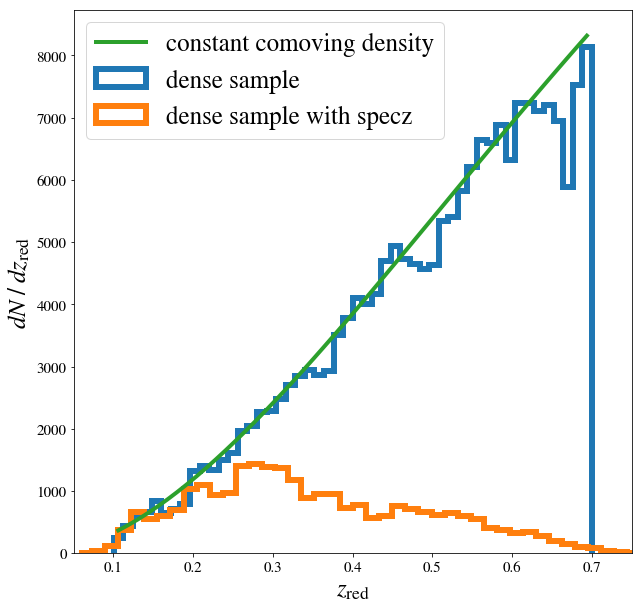

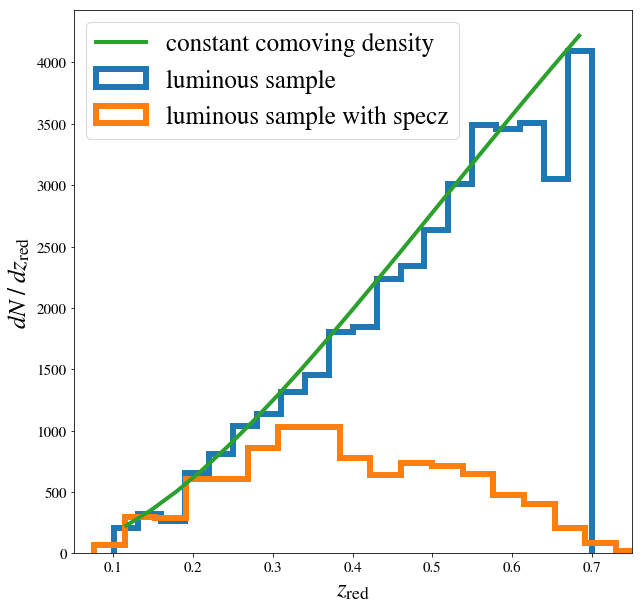

In [29]:
red_spec_dist_dense()
red_spec_dist_lum()

In [34]:
from scipy import stats



def fstd(x):
    
    return np.std(x)

def red_bias_scatter_dense():
    nbins = 12
    bins = np.linspace(0.1 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    y3 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    #running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    #running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    #running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #running_bias_std = [median_absolute_deviation(z2[idx2==k]) for k in range(nbins)]

    
    plt.figure(figsize = (10,10))

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y3, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD")
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", label = "Bias")
    
    print "mean bias" , np.median(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    plt.plot(np.linspace(0.05,0.8,200) , 1.4826*np.mean(np.abs(bin_std))*np.linspace(0.05,0.8,200)/np.linspace(0.05,0.8,200), "r--")

    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{red}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 20)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.009,0.029])
    plt.text( 0.1, 0.025, "dense sample", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    return None



def red_bias_scatter_lum():
    
    nbins = 8
    bins = np.linspace(0.1, 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    y3 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    #running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    #running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    #running_mad3 = [median_absolute_deviation(y3[idx2==k]) for k in range(nbins)]
    #running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y3, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)
    plt.figure(figsize = (10,10))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", label = "Bias")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    plt.plot(np.linspace(0.05,0.8,200) , 1.4826*np.mean(np.abs(bin_std))*np.linspace(0.05,0.8,200)/np.linspace(0.05,0.8,200), "r--")


    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{red}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 20)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.009,0.029])
    plt.text( 0.1, 0.025, "luminous sample", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    return None

def red_bias_scatter_lum_dense():
    
    nbins = 10
    bins = np.linspace(0.11 , 0.69 , nbins)
    delta = bins[1]-bins[0]
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    y3 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    plt.figure(figsize = (10,10))

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD dense", color = "r")
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='mean', 
                                                             bins=bins)
    n, _ = np.histogram(x2, bins=nbins)
    sy, _ = np.histogram(x2, bins=nbins, weights=z2)
    sy2, _ = np.histogram(x2, bins=nbins, weights=z2*z2)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    print "std" , std
    
    
    #bin_means_errs, bin_edges, binnumber = stats.binned_statistic(x2, 
    #                                                         np.abs(z2), 
    #                                                         statistic=fstd, 
    #                                                         bins=bins)
    
    #print bin_means_errs
    
    
    
    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", label = "Bias dense", color = "r")
    
    plt.plot(np.linspace(0.05,0.8,200) , 1.4826*np.mean(np.abs(bin_std))*np.linspace(0.05,0.8,200)/np.linspace(0.05,0.8,200), "r--")

    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    
    
    nbins = 10
    bins = np.linspace(0.11, 0.69 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    y3 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    #running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    #running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    #running_mad3 = [median_absolute_deviation(y3[idx2==k]) for k in range(nbins)]
    #running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD lum", color =  '#1F77B4')

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='mean', 
                                                             bins=bins)
    
    bin_means_errs, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             np.abs(z2), 
                                                             statistic=fstd, 
                                                             bins=bins)
    
    print bin_means_errs
    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", label = "Bias lum", color =  '#1F77B4')

    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(np.abs(bin_std))
    plt.plot(np.linspace(0.05,0.8,200) , 1.4826*np.mean(np.abs(bin_std))*np.linspace(0.05,0.8,200)/np.linspace(0.05,0.8,200), linestyle="dashed", color = '#1F77B4')

    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{\rm red}$" , fontsize= 35)
    plt.ylabel("scatter or bias" , fontsize= 35)
    plt.legend(loc = 'best' , fontsize = 30)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.029,0.029])

    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return None

std [0.01640811 0.01772101 0.02321954 0.02666765 0.02727858 0.02959608
 0.02620772 0.0314458  0.03748486 0.04474889]
mean bias 0.003424323118701666
mean scatter 0.015253468377992152
[0.00845972 0.01063034 0.01360452 0.01742503 0.01776975 0.02384256
 0.01755066 0.02965668 0.02305583]
mean bias 0.0029012650485413585
mean scatter 0.014538933874366581


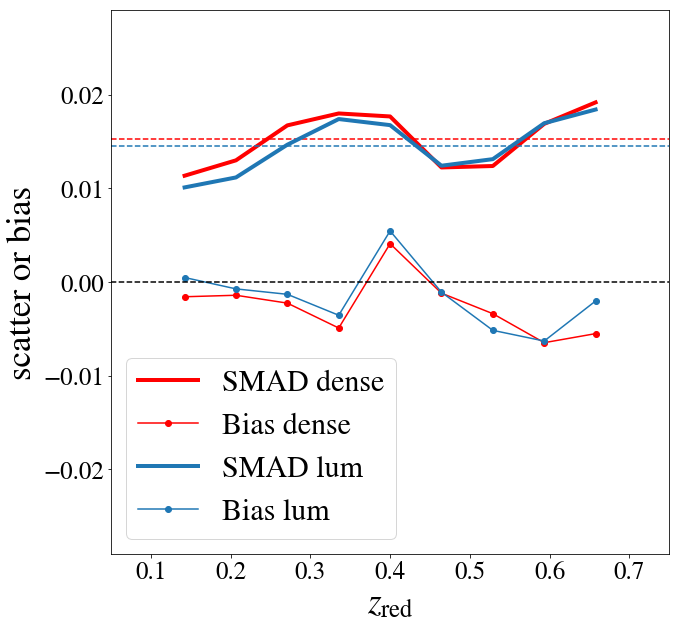

In [35]:
red_bias_scatter_lum_dense()

In [32]:
import corner
from matplotlib import lines as mlines
levels = [0.682689492137086,0.95449973610364]
def red_scatter_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    print ID_dense[mask_one][arg_one] 
    print ID_specall[mask_two][arg_two]
    #print RA[mask_one][arg_one]
    
    out_mask=np.abs(z_dense[mask_one][arg_one]-z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.07
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]

    nspec = len(z_specall[mask_two][arg_two])
    
    plt.figure(figsize=(10,10))

    #corner.hist2d(z_dense[mask_one][arg_one] , z_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
    #              bins=75, levels=levels, fill_contours=True, smooth=0.5, label = "dense sample with spec-z")
    
    zp_all = z_dense[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = .5,c='#1F77B4')
        plt.scatter(zp[~mask], zs[~mask], s= .5, c= '#FF7F0E')
    #plt.scatter(zp_all[out_mask] , zs_all[out_mask], c = "r")    
        
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z, number of spectra = "+str(nspec))
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$5\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.plot(np.linspace(0.0,0.8,10),np.linspace(0.,0.8,10), "k--")
    
    
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$z_{\rm spec}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return None

def red_scatter_lum():
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    nspec = len(z_specall[mask_two][arg_two])
    
    plt.figure(figsize=(10,10))

    
    out_mask =  np.abs(z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.14
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    zp_all = z_lum[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = .5,c='#1F77B4')
        plt.scatter(zp[~mask], zs[~mask], s= .5, c= '#FF7F0E')
    #plt.scatter(zp_all[out_mask] , zs_all[out_mask], c = "r")    
    
    #plt.scatter(z_lum[mask_one][arg_one][out_mask] , z_specall[mask_two][arg_two][out_mask], s= 10.0)
    
    #corner.hist2d(z_lum[mask_one][arg_one] , z_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
    #             bins=30, levels=levels, fill_contours=True, smooth=0.0, label = "dense sample with spec-z")
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z, number of spectra = "+str(nspec))
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$5\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])
    
    plt.plot(np.linspace(0.0,0.8,10),np.linspace(0.,0.8,10), "k--")
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$z_{\rm spec}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    return None

['KIDS J000010.00-312341.17' 'KIDS J000018.23-311724.45'
 'KIDS J000057.88-311103.98' ... 'KIDS J235849.78-331804.02'
 'KIDS J235938.80-331143.09' 'KIDS J235941.87-311831.29']
['KIDS J000010.00-312341.17' 'KIDS J000018.23-311724.45'
 'KIDS J000057.88-311103.98' ... 'KIDS J235849.78-331804.02'
 'KIDS J235938.80-331143.09' 'KIDS J235941.87-311831.29']
percentage outlier fraction 0.460356110181
percentage outlier fraction 0.0630384534566


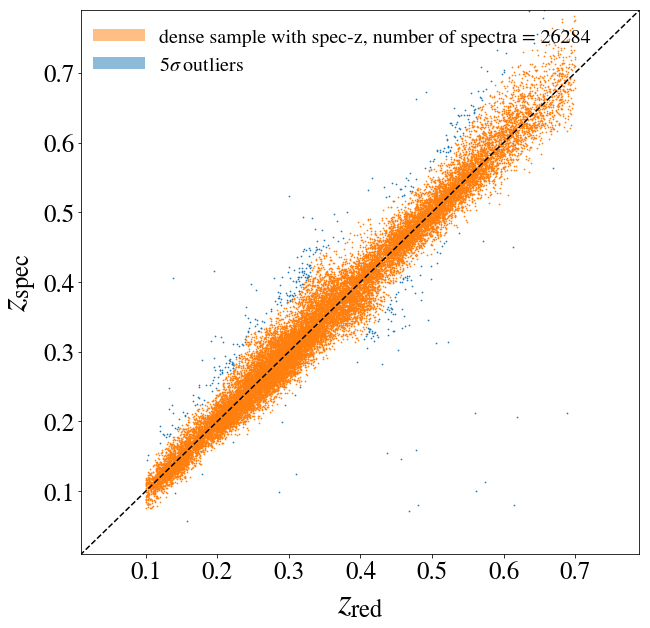

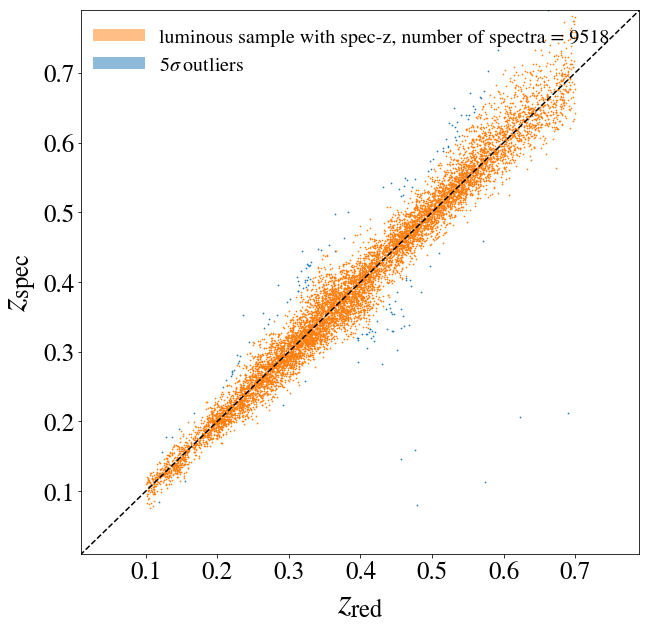

In [51]:
red_scatter_dense()
red_scatter_lum()

In [68]:
import corner
from matplotlib import lines as mlines
levels = [0.682689492137086,0.95449973610364]
def cat_red_scatter_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    print ID_dense[mask_one][arg_one] 
    print ID_specall[mask_two][arg_two]
    #print RA[mask_one][arg_one]
    
    out_mask=np.abs(z_dense[mask_one][arg_one]-z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.07
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]

    nspec = len(z_specall[mask_two][arg_two])
    
    plt.figure(figsize=(10,10))

    zp_all = z_dense[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84.,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 20.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = .5,c='#1F77B4')
        plt.scatter(zp[~mask], zs[~mask], s= .5, c= '#FF7F0E')
        
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z, number of spectra = "+str(nspec))
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$5\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.plot(np.linspace(0.0,0.8,10),np.linspace(0.,0.8,10), "k--")
    
    
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$z_{\rm spec}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return None

def cat_red_scatter_lum():
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    nspec = len(z_specall[mask_two][arg_two])
    
    plt.figure(figsize=(10,10))

    
    out_mask =  np.abs(z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.14
    
    print "percentage outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    zp_all = z_lum[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    bins = np.linspace(0.1,0.7,40)
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84.,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 20.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit        
        plt.scatter(zp[mask], zs[mask], s = 5, c='#1F77B4')
        plt.scatter(zp[~mask], zs[~mask], s= .5, c= '#FF7F0E')
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z, number of spectra = "+str(nspec))
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label=r"$20\sigma \; \mathrm{outliers}$")
    plt.legend(loc='upper left', handles=[thick_line1, thick_line2], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])
    
    plt.plot(np.linspace(0.0,0.8,10),np.linspace(0.,0.8,10), "k--")
    plt.xlim((0.01,0.79))
    plt.ylim((0.01,0.79))
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$z_{\rm spec}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    return None

percentage outlier fraction 0.0630384534566


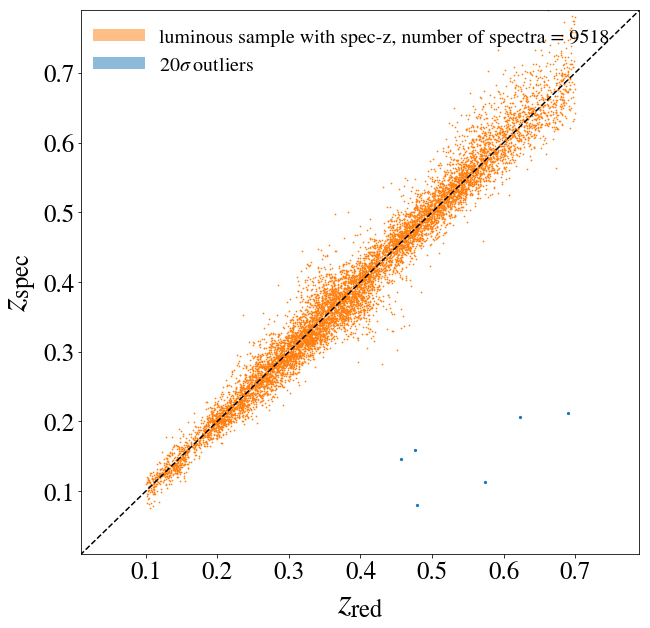

In [69]:
cat_red_scatter_lum()

In [36]:
import corner
from matplotlib import lines as mlines
levels = [0.68,0.95,0.99]


def red_mag_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample")
    
    corner.hist2d(z_dense[mask_one][arg_one] , mi_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                 bins=100, levels=levels, fill_contours=True, smooth=1.0)
    
    corner.hist2d(z_dense , mi_dense, color='#1F77B4', plot_datapoints=False,
                 bins=100, levels=levels, fill_contours=True, smooth=1.0)
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])

    plt.xlim((0.05,0.75))
    plt.ylim(16,22)

    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$i-\mathrm{band} \; \; \mathrm{magnitude}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    return None

def red_mag_dense_cutout():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample")
    
    corner.hist2d(z_dense[mask_one][arg_one][z_dense[mask_one][arg_one]<0.4] , 
                  mi_specall[mask_two][arg_two][[z_dense[mask_one][arg_one]<0.4]], 
                  color='#FF7F0E', plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=2.0)
    
    corner.hist2d(z_dense[z_dense<0.4] , mi_dense[z_dense<0.4], color='#1F77B4', plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=2.0)
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])

    plt.xlim((0.05,0.75))
    plt.ylim(16,22)

    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$i-\mathrm{band} \; \; \mathrm{magnitude}$" , fontsize = 35)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None    
    

def red_mag_lum():
    
    mask_one = np.where((np.in1d(ID_lum , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    plt.figure(figsize=(10,10))

    
    corner.hist2d(z_lum[mask_one][arg_one] , mi_specall[mask_two][arg_two], color='#FF7F0E', plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=1.0, label = "luminous sample with spec-z")
    corner.hist2d(z_lum , mi_lum, color='#1F77B4',plot_datapoints=False,
                 bins=50, levels=levels, fill_contours=True, smooth=1.0, label = "luminous sample")
    thick_line1 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=20, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((0.05,0.75))
    plt.ylim(16,22)
    plt.xlabel(r"$z_{\rm red}$" , fontsize = 35)
    plt.ylabel(r"$i-\mathrm{band} \; \; \mathrm{magnitude}$" , fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    return None

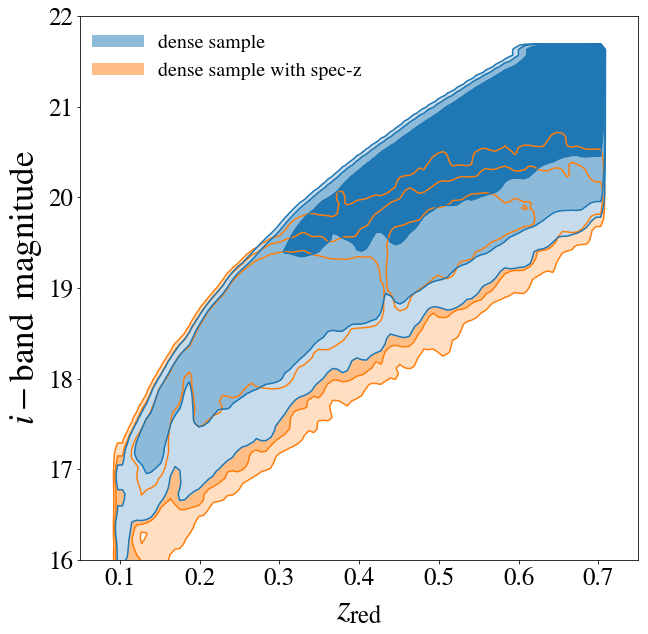

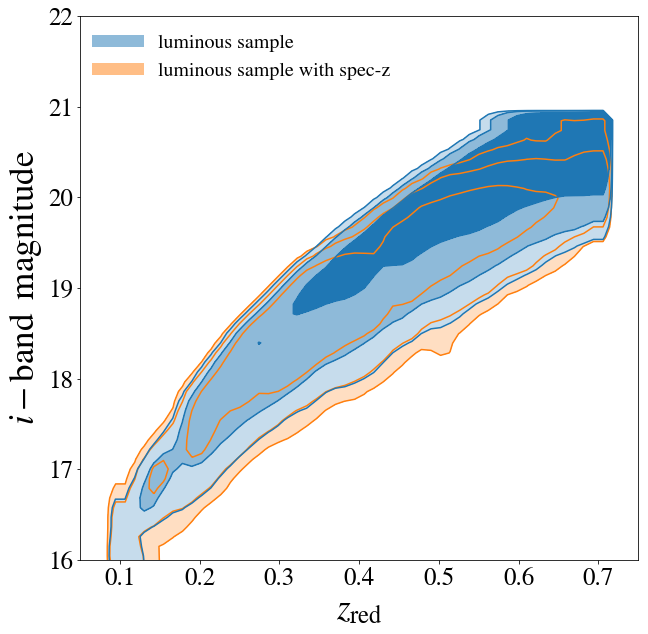

In [37]:
red_mag_dense()
red_mag_lum()
#red_mag_dense_cutout()

In [38]:
def outlier_dense():
    
    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    #out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    #mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    zs_all = z_specall[mask_two][arg_two]
    
    plt.figure(figsize=(8,5))

    bins = np.linspace(0.1,0.7,12)
    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    #print "mean sigma rate" , np.median(np.array(rate))

    #plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)
    #plt.plot(0.5*(bins[1:]+bins[:-1]) , np.array(rate), lw = 2, label = "luminous sample")    

    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean sigma rate" , np.median(np.array(rate))
    plt.plot(0.5*(bins[1:]+bins[:-1]) , np.array(rate), lw = 2, label = "dense sample")    


    #######################################################################################################3
    mask_one = np.where((np.in1d(ID_lum , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_lum[mask_one][arg_one][out_mask]
    zp_all = z_lum[mask_one][arg_one]
    zs_all = z_spec[mask_two][arg_two]
    
    bins = np.linspace(0.1,0.7,12)
    rate = []
    err = []
   
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))

    rate = []
    err = []
    for k in range(len(bins)-1):
        
        zp = zp_all[(zp_all>bins[k])&(zp_all<bins[k+1])] 
        zs = zs_all[(zp_all>bins[k])&(zp_all<bins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./len(mask))  
        err.append(len(mask[mask==True])*.5/len(mask))
        
    print "mean sigma rate" , np.median(np.array(rate))
    #plt.errorbar(0.5*(bins[1:]+bins[:-1]) , np.array(rate), err, lw = 2, fmt='-o' , capsize=3)    
    plt.plot(0.5*(bins[1:]+bins[:-1]) , np.array(rate), lw = 2, label = "luminous sample")    
    plt.legend(fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks([0.00, 0.02,0.04,0.06,0.08], fontsize = 15)
    plt.xlabel("photometric redshift" , fontsize = 15)
    plt.ylabel(r"$5\sigma \; \mathrm{Outlier \; Rate}$", fontsize = 15)
    #plt.text( 0.2, 0.01, "Dense sample", fontsize = 20)

     
    return None

mean sigma rate 0.013402375875723424
mean sigma rate 0.013029315960912053


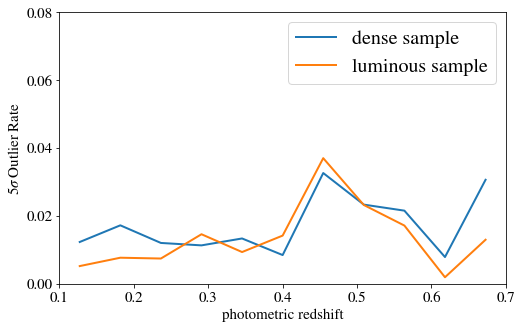

In [39]:
outlier_dense()

In [22]:
def outlier_clump(zmin, zmax):
    
    mask_one = np.where((np.in1d(ID_dense , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    
    ras_all = RA_spec[mask_two][arg_two]
    des_all = DEC_spec[mask_two][arg_two]
    zs_all = z_spec[mask_two][arg_two]
    

    zp = zp_all[(zp_all>zmin)&(zp_all<zmax)]
    zs = zs_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ras = ras_all[(zp_all>zmin)&(zp_all<zmax)]
    decs = des_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ez = (zp - zs)
    x75, x25 = np.percentile(ez,[84,16.])
    sz = (x75 - x25)/2
    out_limit = 5.*sz 
    core_limit = 0.02*sz
    out_mask = np.abs(zs-zp) > out_limit
    core_mask = np.abs(zs-zp) < core_limit
    
    out_ra=ras[out_mask]
    out_dec=decs[out_mask]
    core_ra=ras[core_mask]
    core_dec=decs[core_mask]
    
    print "out_ra" , out_ra
    print "out_dec", out_dec
    
    print "core_ra" , core_ra
    print "core_dec", core_dec
    
    plt.figure(figsize=(6,6))
    plt.scatter(out_ra, out_dec , label = "outlier")
    plt.scatter(core_ra, core_dec , label = "good")

    plt.legend()
     
    return None


In [48]:
def outlier_clump(zmin, zmax):
    
    mask_one = np.where((np.in1d(ID_dense , ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])>0.08
    mask_lum = z_dense[mask_one][arg_one][out_mask]
    zp_all = z_dense[mask_one][arg_one]
    
    ras_all = RA_spec[mask_two][arg_two]
    des_all = DEC_spec[mask_two][arg_two]
    zs_all = z_spec[mask_two][arg_two]
    cs_all = colors_spec[mask_two][arg_two]
    mi_all = mi_spec[mask_two][arg_two]
    zp = zp_all[(zp_all>zmin)&(zp_all<zmax)]
    zs = zs_all[(zp_all>zmin)&(zp_all<zmax)]
    cs = cs_all[(zp_all>zmin)&(zp_all<zmax)]
    mis = mi_all[(zp_all>zmin)&(zp_all<zmax)]

    
    ras = ras_all[(zp_all>zmin)&(zp_all<zmax)]
    decs = des_all[(zp_all>zmin)&(zp_all<zmax)]
    
    ez = (zp - zs)/(1+zs)
    x75, x25 = np.percentile(ez,[84,16.])
    sz = (x75 - x25)/2
    sz = median_absolute_deviation(ez)
    out_limit = 5.*sz 
    core_limit = 2.*sz
    out_mask = np.abs(zs-zp)/(1.+zs) > out_limit
    core_mask = np.abs(zs-zp)/(1.+zs) < core_limit
    
    out_ra=ras[out_mask]
    out_dec=decs[out_mask]
    core_ra=ras[core_mask]
    core_dec=decs[core_mask]
    
    #print core_ra
    #print core_dec
    #print out_ra
    #print out_dec
    
    out_cs = cs[out_mask]
    out_mis = mis[out_mask]
    core_cs = cs[core_mask]
    core_mis = mis[core_mask]
    
    
    plt.figure(figsize=(6,6))
    plt.scatter(core_cs[:,0], core_cs[:,1], label = "0.01-sigma precise")

    plt.scatter(out_cs[:,0], out_cs[:,1] , label = "5-sigma outlier")
    plt.xlabel("mi", fontsize = 20)
    plt.ylabel("u-g", fontsize = 20)
    plt.legend()
    #plt.ylim([0,3.5])
     
    return None

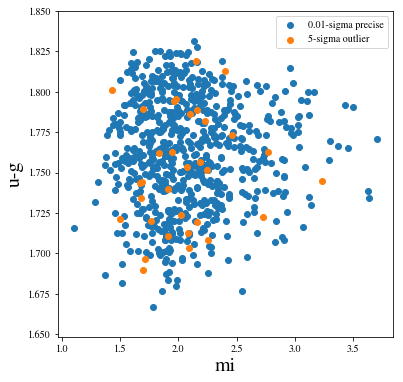

In [50]:
outlier_clump(0.44,0.46)

In [25]:
from scipy import stats

mean bias 0.0012363232988439055
mean scatter 0.01535125068066246
mean bias 0.0019133558277629747
mean scatter 0.014653039292622969


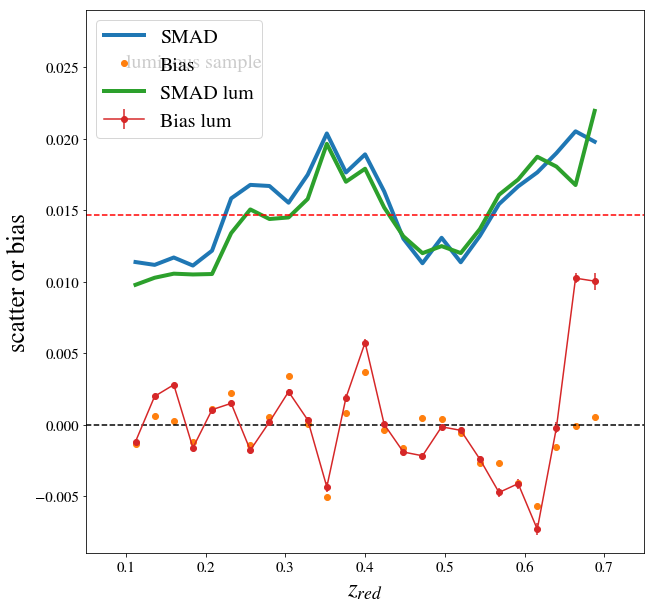

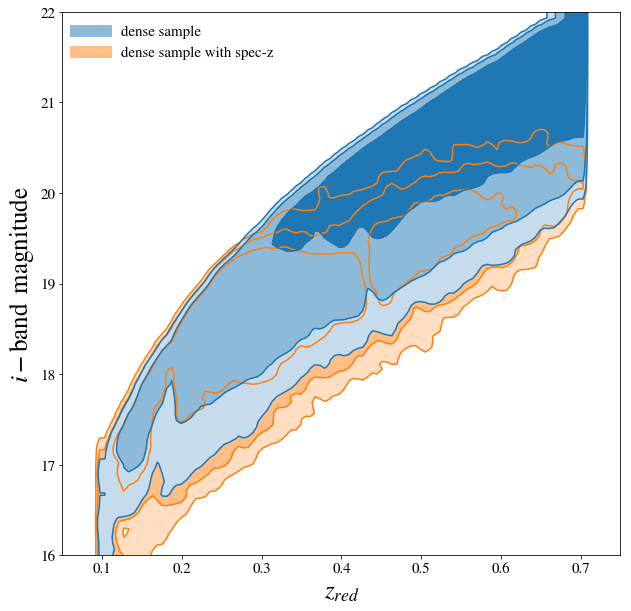

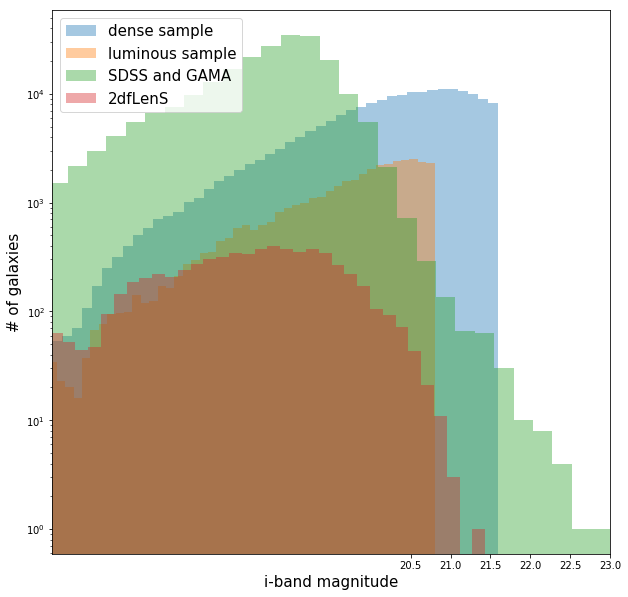

In [86]:
plt.figure(figsize = (10,10))
sns.distplot(mi_dense , kde =False , label="dense sample")
sns.distplot(mi_lum , kde = False , label = "luminous sample")
sns.distplot(mi_spec , kde = False , label = "SDSS and GAMA")
sns.distplot(mi_2df , kde = False , label = "2dfLenS")
plt.xticks([20.5,21,21.5,22,22.5,23])
plt.xlim([16,23])
plt.legend(loc='best' , fontsize = 15)
plt.xlabel("i-band magnitude" , fontsize = 15)
plt.ylabel("# of galaxies" , fontsize = 15)
plt.yscale("log")

In [76]:
def mi_bias_scatter_dense_2df():
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.5),nbins)
    delta = bins[1]-bins[0]
    
    scatter
    
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.figure(figsize = (10,10))
    plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
   
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    #lt.xlim([0.05,0.75])
    plt.ylim([-0.1,0.04])

    #lt.text( 0.2, 0.02, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None



def mi_bias_scatter_lum_2df():
    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(20.5),nbins)
    print bins
    delta = bins[1]-bins[0]
    
   
    
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.figure(figsize = (10,10))
    #lt.plot(bins , running_sigma682 , lw= 4, label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    #plt.errorbar(bins , running_bias , yerr = running_bias_std, color = "blue" , label = r"$\mathrm{bias} \; \delta z$")
    #lt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    #plt.title(r"$L/L_{\star}>1$" , fontsize = 25)
    plt.legend(loc = 'best' , fontsize = 10)
    #lt.xlim([0.05,0.75])
    plt.ylim([-0.1,0.04])

    #lt.text( 0.2, 0.02, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None

In [77]:
mi_bias_scatter_dense_2df()
mi_bias_scatter_lum_2df()

IndexError: cannot do a non-empty take from an empty axes.

In [89]:
def mi_bias_scatter_dense_spec():
    plt.figure(figsize = (10,10))

    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    plt.figure(figsize = (10,10))
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(16,21.5,10))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD")
    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(16,21.5,10))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", label = "Bias")
  
    """
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)

    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    """
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.045])
    
    return None



def mi_bias_scatter_lum_spec():
    
    plt.figure(figsize = (10,10))

    
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    y2 = (z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    plt.figure(figsize = (10,10))
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(16,20.8,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std ,lw = 4, label = "SMAD")
    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(16,20.8,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", label = "Bias")
    
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    #plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    #plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    """
    nbins = 10
    bins = np.logspace(np.log10(17.5),np.log10(21.),nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_lum[mask_one][arg_one])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = mi_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    """
    plt.xlabel(r"$m_i$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.02,0.035])

    return None


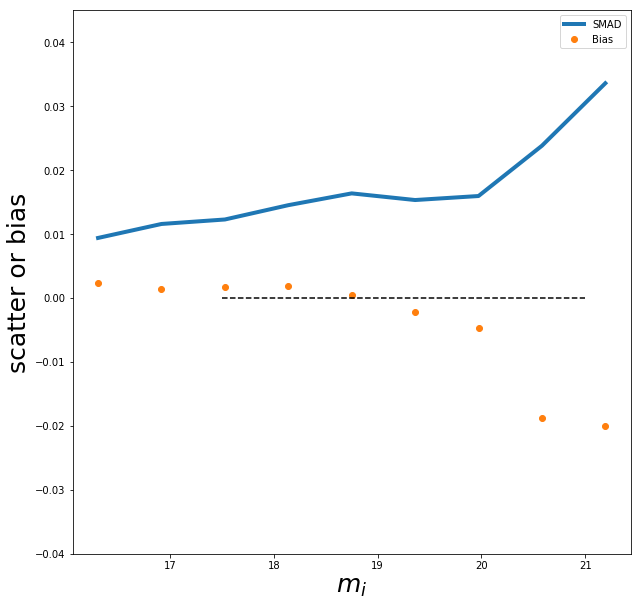

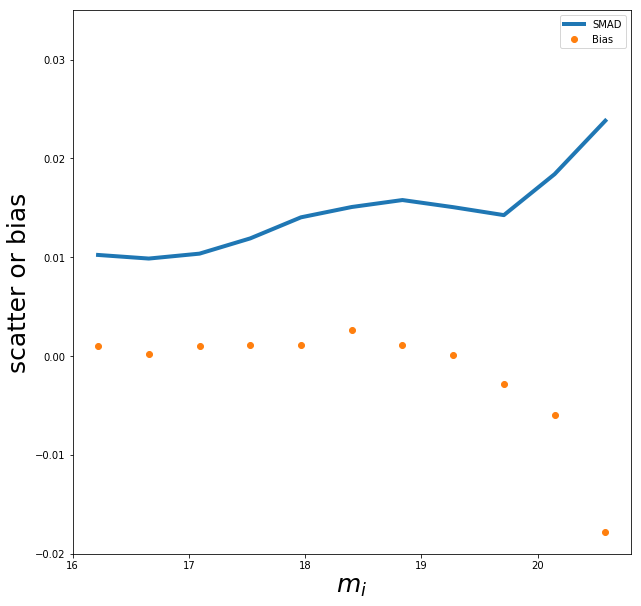

In [90]:
mi_bias_scatter_dense_spec()
mi_bias_scatter_lum_spec()

In [91]:
def z_bias_scatter_dense_spec():
    plt.figure(figsize = (10,10))

    
    nbins = 15
    bins = np.linspace(0.11,0.7,nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    print arg_two.shape , "specx dense lrg"

    y2 = (z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    #plt.plot(bins , -1.*running_mad2 ,lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 15
    bins = np.linspace(0.11,0.7,nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_dense, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    print arg_two.shape , "2df x dense lrg"

    y2 = (z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)

    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$z$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])
    
    return None



def z_bias_scatter_lum_spec():
    
    plt.figure(figsize = (10,10))

    
    nbins = 15
    bins = np.linspace(0.15,0.7,nbins)
    delta = bins[1]-bins[0]

    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    print arg_two.shape , "specxlrg"

    y2 = (z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_spec[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    nbins = 15
    bins = np.linspace(0.15,0.7,nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(ID_lum, ID_2df)==True))[0]
    mask_two = np.where((np.in1d(ID_2df,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_2df[mask_two])
    print arg_two.shape , "2dfxlrg"
    y2 = (z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two])/(1+z_spec[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_2df[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    #plt.plot(bins , running_mad2 , lw = 4, label = "scatter")
    plt.fill_between(bins , -1.*np.array(running_mad2) , running_mad2, alpha = 0.2)
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", label = r"$\mathrm{bias} \; \delta z$")
    
    
    plt.plot(bins , 0.0*bins, "k--")
    plt.xlabel(r"$z$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.ylim([-0.04,0.025])

    return None


(25728,) specx dense lrg
(1046,) 2df x dense lrg
(9163,) specxlrg
(455,) 2dfxlrg


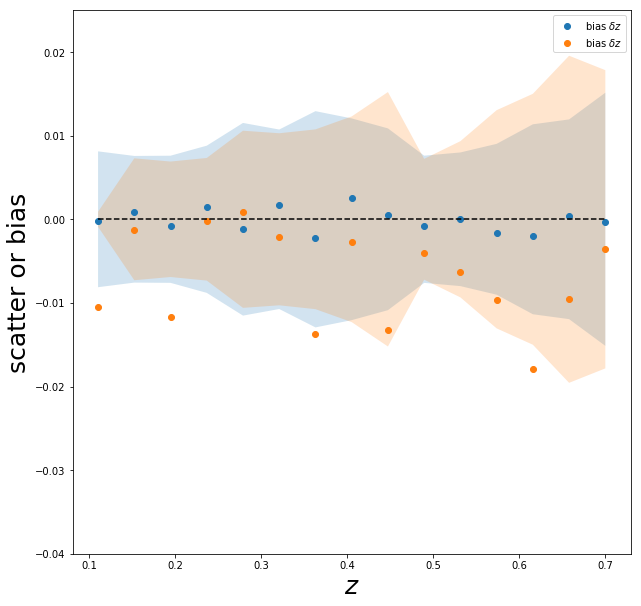

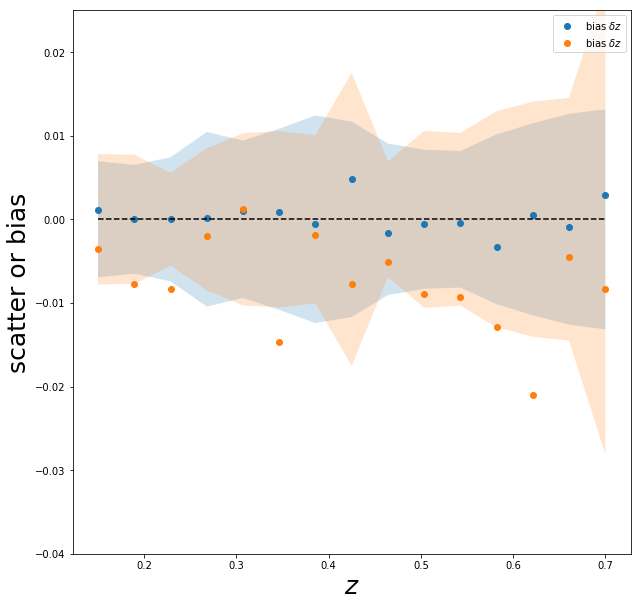

In [92]:
z_bias_scatter_dense_spec()
z_bias_scatter_lum_spec()

In [65]:
mask_one = np.where((np.in1d(ID_kids , ID_2df)==True))[0]
mask_two = np.where((np.in1d(ID_2df  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_2df[mask_two])

In [40]:
colors_2df = colors[mask_one][arg_one]
mi_2df = mi[mask_one][arg_one]
z_2df_sort = z_2df[mask_two][arg_two]

NameError: name 'color_spec' is not defined

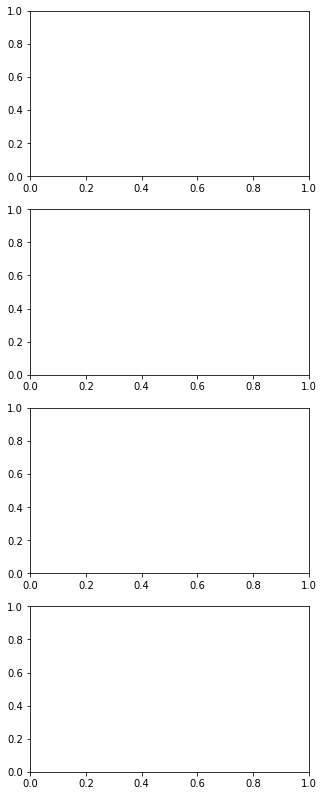

In [41]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec, mi_spec, s= 0.001)

ax[0].scatter(z_2df_sort , colors_2df[:,0] , s = 0.05 )
ax[1].scatter(z_2df_sort , colors_2df[:,1] , s = 0.05)
ax[2].scatter(z_2df_sort , colors_2df[:,2] , s = 0.05)
ax[3].scatter(z_2df_sort, mi_2df, s= 0.05)


ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)
ax[2].set_xticks([])

ax[3].set_xlim(0,0.8)


ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [ ]:
colors_2df[:,0].shape

In [ ]:
mask_one = np.where((np.in1d(ID_kids , ID_dense)==True))[0]
mask_two = np.where((np.in1d(ID_dense  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_dense[mask_two])
colors_dense = colors[mask_one][arg_one]
mi_dense = mi[mask_one][arg_one]
z_dense_sort = z_dense[mask_two][arg_two]

In [ ]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec , mi_spec , s = 0.01)


ax[0].scatter(z_dense_sort , colors_dense[:,0] , s = 0.001 )
ax[1].scatter(z_dense_sort , colors_dense[:,1] , s = 0.001)
ax[2].scatter(z_dense_sort , colors_dense[:,2] , s = 0.001)
ax[3].scatter(z_dense_sort, mi_dense, s= 0.01)

ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)

ax[3].set_xlim(0,0.8)


ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [ ]:
mask_one = np.where((np.in1d(ID_kids , ID_lum)==True))[0]
mask_two = np.where((np.in1d(ID_lum  , ID_kids[mask_one])==True))[0]


arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_lum[mask_two])

In [ ]:
colors_lum = colors[mask_one][arg_one]
z_lum_sort = z_lum[mask_two][arg_two]
mi_lum = mi[mask_one][arg_one]

In [ ]:
fig , ax = plt.subplots(nrows=4,ncols=1 , figsize=(5,14))


ax[0].scatter(z_spec , color_spec[:,0] , s = 0.001 )
ax[1].scatter(z_spec , color_spec[:,1] , s = 0.001)
ax[2].scatter(z_spec , color_spec[:,2] , s = 0.001)
ax[3].scatter(z_spec, mi_spec, s= .001)

ax[0].scatter(z_lum_sort , colors_lum[:,0] , s = 0.001 )
ax[1].scatter(z_lum_sort , colors_lum[:,1] , s = 0.001)
ax[2].scatter(z_lum_sort , colors_lum[:,2] , s = 0.001)
ax[3].scatter(z_lum_sort, mi_lum, s = 0.01)

ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,3)
ax[0].set_xticks([])

ax[1].set_xlim(0,0.8)
ax[1].set_ylim(0,2.5)
ax[1].set_xticks([])

ax[2].set_xlim(0,0.8)
ax[2].set_ylim(0,1.5)
ax[2].set_xticks([])

ax[3].set_xlim(0,0.8)

ax[3].set_xlabel(r"$z$" , fontsize = 20)
ax[0].set_ylabel(r"$u-g$" , fontsize = 20)
ax[1].set_ylabel(r"$g-r$" , fontsize = 20)
ax[2].set_ylabel(r"$r-i$" , fontsize = 20)
ax[3].set_ylabel(r"$m_i$" , fontsize = 20)

plt.tight_layout()

In [ ]:
def red_bias_scatter_dense():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.11 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_dense[mask_one][arg_one])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)

    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    
    plt.plot(bins , running_mad2 , lw = 4, color = '#FF7F0E', label = "mad redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "bias redMaGiC")
    
    
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , running_mad2 , lw = 4, color = '#1F77B4', label = "mad ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "bias ANNz2")
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.05,0.05])
    plt.text( 0.2, 0.03, "$L/L_{\star}>0.5$", fontsize = 30)

    
    return None

In [ ]:
red_bias_scatter_dense()

In [66]:
def red_bias_scatter_dense():
    plt.figure(figsize = (10,10))
    nbins = 8
    bins = np.linspace(0.13 , 0.67 , nbins)
    delta = bins[1]-bins[0]
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    

    obins = np.linspace(0.1,0.7, nbins+10)
    rate = []
    err = []
    zs_all = z_specall[mask_two][arg_two]
    zp_all = z_dense[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True]))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)

    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]

    print "mean bias" , np.median(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.median(running_mad2)
    out_mask =  np.abs(z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0/out_mask.shape[0]
    
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#FF7F0E', label = "SMAD redMaGiC")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#FF7F0E', label = "Bias redMaGiC")
    #######################################################################################################
    
    nbins = 8
    bins = np.linspace(0.13 , 0.67 , nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(bright_z_ID, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])
    z2 = bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = bright_z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    obins = np.linspace(0.1,0.7, nbins+10)
    rate = []
    err = []
    zs_all = bright_z_ann[mask_one][arg_one]
    zp_all = z_spec_matched_to_dense[mask_two][arg_two]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True]))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)
    
    
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.median(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.median(running_mad2)
    out_mask =  np.abs(bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0/out_mask.shape[0]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = "g", label = "SMAD bright ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, color = "g", marker = "o", label = "Bias bright ANNz2")
    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_ann[mask_one][arg_one])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    obins = np.linspace(0.1,0.7, nbins+10)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_ann[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True]))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)
    
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.median(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.median(running_mad2)
    out_mask =  np.abs(z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0/out_mask.shape[0]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = '#1F77B4', label = "SMAD fiducial ANNz2")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = '#1F77B4', label = "Bias fiducial ANNz2")
    
    nbins = 8
    bins = np.linspace(0.13 , 0.67 , nbins)
    delta = bins[1]-bins[0]
    
    y2 = (z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])
    z2 = z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_bpz[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    
    obins = np.linspace(0.1,0.7, nbins+10)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_bpz[mask_one][arg_one]
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        x75, x25 = np.percentile(ez,[84,16.])
        sz = (x75 - x25)/2
        outlier_limit = 5.*sz
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True]))  
        err.append(len(mask[mask==True])*.5/len(mask))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)
    
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    print "mean bias" , np.median(np.abs(running_bias2))
    print "mean scatter" , 1.4826*np.median(running_mad2)
    out_mask =  np.abs(z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0/out_mask.shape[0]
    
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    plt.plot(bins , 1.4826*np.array(running_mad2) , lw = 4, color = 'red', label = "SMAD BPZ")
    plt.plot(bins , running_bias2 , lw = 0, marker = "o", color = 'red', label = "Bias BPZ")
    
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.06,0.06])
    plt.text( 0.1, 0.045, "Dense sample", fontsize = 20)

    
    return None

mean 5- sigma rate 0.26891760663330094
mean bias 0.000825571694857058
mean scatter 0.014701192159164461
5sigma outlier fraction 0.00268917606633
mean 5- sigma rate 0.233131584846447
mean bias 0.0018467009087287795
mean scatter 0.013273561290298462
5sigma outlier fraction 0.00183815288052
mean 5- sigma rate 0.15313363711062972
mean bias 0.005916207999302505
mean scatter 0.017457295329639327
5sigma outlier fraction 0.00399641443191
mean 5- sigma rate 0.145663703593038
mean bias 0.01725999265909195
mean scatter 0.01869439138746249
5sigma outlier fraction 0.00537835213267


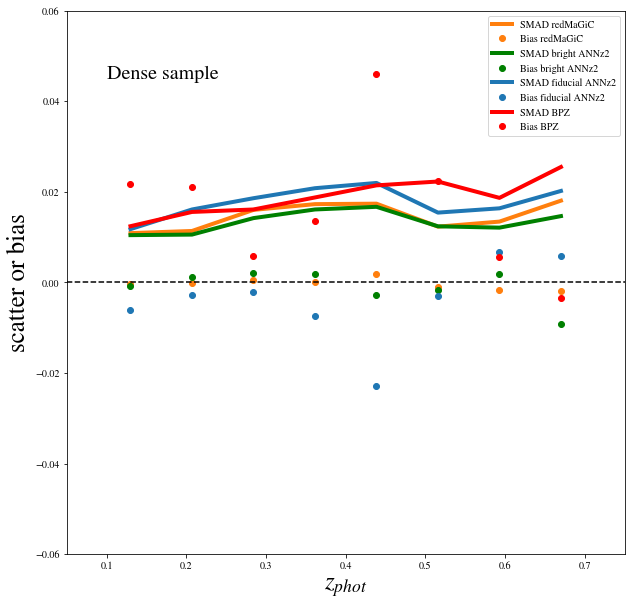

In [67]:
red_bias_scatter_dense()

In [69]:
def outlier_dense():
    
    plt.figure(figsize = (10,10))
    nbins = 21

    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_specall[mask_two][arg_two]
    zp_all = z_dense[mask_one][arg_one]
    out = []
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit redmagic" , outlier_limit
        out.append(outlier_limit)
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    print "redmagic outlier" , np.array(out) , np.median(np.array(out)) 
    
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2 , label = "redMaGiC")


    #######################################################################################################

    mask_one = np.where((np.in1d(bright_z_ID, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zp_all = bright_z_ann[mask_one][arg_one]
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit bright annz",  outlier_limit        
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2, label = "bright ANNz2")

    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_ann[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit annz",  outlier_limit

        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2, label = "fiducial ANNz2")




    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_bpz[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit bpz",  outlier_limit
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1.0/(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2 ,label = "BPZ")

    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("5-sigma outlier rate" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([0,0.06])
    #plt.text( 0.1, 0.045, "Dense sample", fontsize = 20)

    
    return None

outlier limit redmagic 0.03664634685871087
outlier limit redmagic 0.03931592066992651
outlier limit redmagic 0.037059031440071284
outlier limit redmagic 0.040142617577795
outlier limit redmagic 0.05632822721490531
outlier limit redmagic 0.05596611850779177
outlier limit redmagic 0.05285453704654861
outlier limit redmagic 0.057537464698632024
outlier limit redmagic 0.06633586937197604
outlier limit redmagic 0.0609281117143516
outlier limit redmagic 0.05781927296569973
outlier limit redmagic 0.04404720048871622
outlier limit redmagic 0.03838630778562157
outlier limit redmagic 0.04205683664508391
outlier limit redmagic 0.04130223573242042
outlier limit redmagic 0.04926593159424236
outlier limit redmagic 0.05777981811970456
outlier limit redmagic 0.059595611183360826
outlier limit redmagic 0.0579176128557279
outlier limit redmagic 0.07835513697830951
redmagic outlier [0.03664635 0.03931592 0.03705903 0.04014262 0.05632823 0.05596612
 0.05285454 0.05753746 0.06633587 0.06092811 0.05781927 0

/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/local/lib64/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


outlier limit annz 0.03934257716372981
outlier limit annz 0.05277181410913731
outlier limit annz 0.05755293829459723
outlier limit annz 0.05016134028950497
outlier limit annz 0.06582494057290887
outlier limit annz 0.06305465380057095
outlier limit annz 0.060695184097998414
outlier limit annz 0.0706619539394459
outlier limit annz 0.06962290178199444
outlier limit annz 0.073603484579086
outlier limit annz 0.07314554025160391
outlier limit annz 0.05631120973265908
outlier limit annz 0.049411714027290984
outlier limit annz 0.05153531585029878
outlier limit annz 0.052085157344878494
outlier limit annz 0.057007336426223576
outlier limit annz 0.06154434165025596
outlier limit annz 0.06449463492112731
outlier limit annz 0.07516954343314677
outlier limit annz 0.08813798307100294
outlier limit bpz 0.06781185280606189
outlier limit bpz 0.04548654431025929
outlier limit bpz 0.0552485527201938
outlier limit bpz 0.043436566764679704
outlier limit bpz 0.05636211301330713
outlier limit bpz 0.057895735

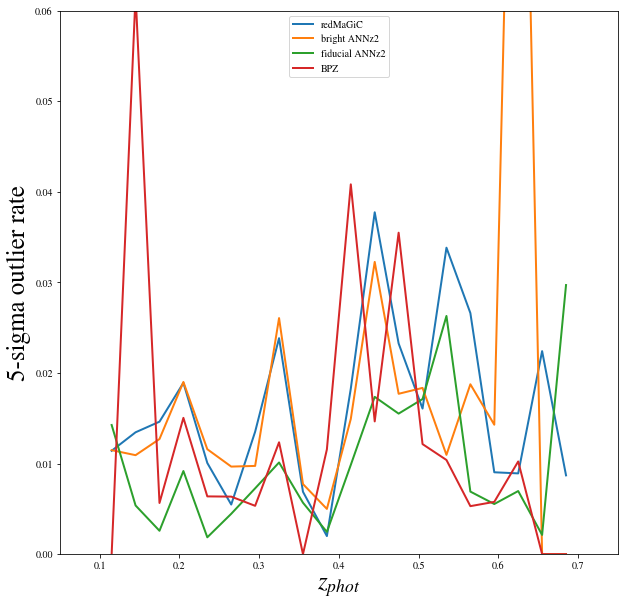

In [70]:
outlier_dense()

In [71]:
def badfraction_dense():
    
   
    nbins = 14

    mask_one = np.where((np.in1d(ID_dense , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    
    obins = np.linspace(0.1,0.7, nbins)
    
    zs_all = z_specall[mask_two][arg_two]
    zp_all = z_dense[mask_one][arg_one]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.05441032777717019 #Thus roughly corresponds to 5sigma 
    print "bad fraction redmagic" , len(mask[mask==True])*1.0/len(mask)

    #######################################################################################################

    mask_one = np.where((np.in1d(bright_z_ID, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zp_all = bright_z_ann[mask_one][arg_one]
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.0546210645915812
    print "bad fraction bright annz" , len(mask[mask==True])*1.0/len(mask)

    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_ann[mask_one][arg_one]

    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.0546210645915812
    print "bad fraction fiducial annz" , len(mask[mask==True])*1.0/len(mask)

    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_dense[mask_two][arg_two]
    zp_all = z_bpz[mask_one][arg_one]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.0546210645915812
    print "bad fraction bpz" , len(mask[mask==True])*1.0/len(mask)
    
    
    return None

In [72]:
badfraction_dense()

bad fraction redmagic 0.0132591319937
bad fraction bright annz 0.00928043039677
bad fraction fiducial annz 0.0152760140435
bad fraction bpz 0.0423918727123


In [73]:
def outlier_lum():
    
    plt.figure(figsize = (10,10))
    nbins = 21

    mask_one = np.where((np.in1d(ID_lum , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_lum_copy = ID_lum[mask_one][arg_one]
    z_spec_matched_to_lum = z_specall[mask_two][arg_two]
    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_specall[mask_two][arg_two]
    zp_all = z_lum[mask_one][arg_one]
    out = []
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit redmagic" , outlier_limit
        out.append(outlier_limit)
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    print "redmagic outlier" , np.array(out) , np.median(np.array(out)) 
    
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2 , label = "redMaGiC")


    #######################################################################################################

    mask_one = np.where((np.in1d(bright_z_ID, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zp_all = bright_z_ann[mask_one][arg_one]
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit bright annz",  outlier_limit        
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2, label = "bright ANNz2")

    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    zp_all = z_ann[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit annz",  outlier_limit

        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1./(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2, label = "fiducial ANNz2")




    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    zp_all = z_bpz[mask_one][arg_one]
    
    for k in range(len(obins)-1):
        
        zp = zp_all[(zp_all>obins[k])&(zp_all<obins[k+1])] 
        zs = zs_all[(zp_all>obins[k])&(zp_all<obins[k+1])]
        ez = (zp - zs)/(1+zs)
        #x75, x25 = np.percentile(ez,[84,16.])
        #sz = (x75 - x25)/2
        sz = median_absolute_deviation(ez)
        outlier_limit = 5.*sz
        print "outlier limit bpz",  outlier_limit
        mask = np.abs(zs-zp)/(1+zs) > outlier_limit
        rate.append(len(mask[mask==True])*1.0/(len(mask)+0.001))  
        err.append(len(mask[mask==True])*.5/(len(mask)+0.001))
    print "mean 5- sigma rate" , np.sum(np.array(rate))*100./len(zs_all)
    plt.plot(0.5*(obins[1:]+obins[:-1]) , np.array(rate), lw = 2 ,label = "BPZ")

    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("5-sigma outlier rate" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([0,0.1])
    #plt.text( 0.1, 0.045, "Dense sample", fontsize = 20)

    
    return None

outlier limit redmagic 0.03319043325460802
outlier limit redmagic 0.033996335037381115
outlier limit redmagic 0.035419889230807494
outlier limit redmagic 0.03565710358611024
outlier limit redmagic 0.04924408212279897
outlier limit redmagic 0.049693084936924876
outlier limit redmagic 0.04759203058983684
outlier limit redmagic 0.05306885985226154
outlier limit redmagic 0.0650715802195305
outlier limit redmagic 0.05801446893972561
outlier limit redmagic 0.056936560546579446
outlier limit redmagic 0.04498140028236362
outlier limit redmagic 0.04050795394238843
outlier limit redmagic 0.040107333217709595
outlier limit redmagic 0.04390845568619208
outlier limit redmagic 0.0532885750500435
outlier limit redmagic 0.05897463463906427
outlier limit redmagic 0.059822617074039026
outlier limit redmagic 0.05954005209992254
outlier limit redmagic 0.07588712022375815
redmagic outlier [0.03319043 0.03399634 0.03541989 0.0356571  0.04924408 0.04969308
 0.04759203 0.05306886 0.06507158 0.05801447 0.05693

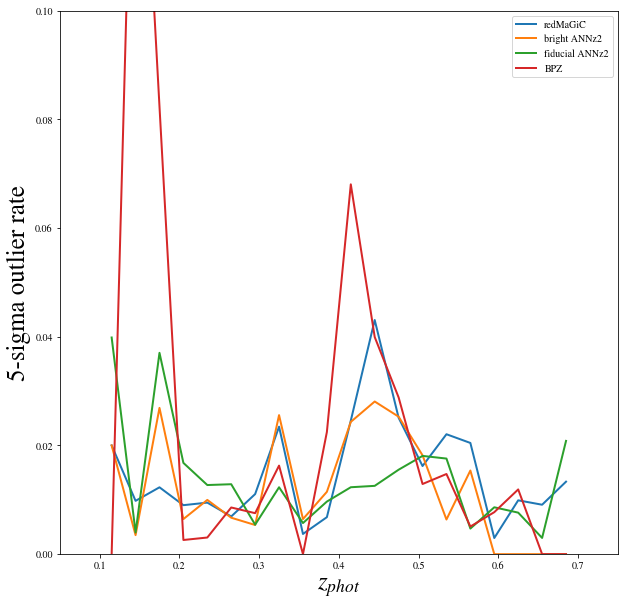

In [74]:
outlier_lum()

In [75]:
def badfraction_lum():
    
   
    nbins = 14

    mask_one = np.where((np.in1d(ID_lum , ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_lum_copy = ID_lum[mask_one][arg_one]
    z_spec_matched_to_lum = z_specall[mask_two][arg_two]
    
    
    obins = np.linspace(0.1,0.7, nbins)
    
    zs_all = z_specall[mask_two][arg_two]
    zp_all = z_lum[mask_one][arg_one]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.04946858352986192 #Thus roughly corresponds to 5sigma 
    print "bad fraction redmagic" , len(mask[mask==True])*1.0/len(mask)

    #######################################################################################################

    mask_one = np.where((np.in1d(bright_z_ID, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zp_all = bright_z_ann[mask_one][arg_one]
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.04946858352986192
    print "bad fraction bright annz" , len(mask[mask==True])*1.0/len(mask)

    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    zp_all = z_ann[mask_one][arg_one]

    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.04946858352986192
    print "bad fraction fiducial annz" , len(mask[mask==True])*1.0/len(mask)

    
    obins = np.linspace(0.1,0.7, nbins)
    rate = []
    err = []
    zs_all = z_spec_matched_to_lum[mask_two][arg_two]
    zp_all = z_bpz[mask_one][arg_one]
    
    ez = np.abs(zs_all - zp_all)/(1+zs_all)
    mask = ez > 0.04946858352986192
    print "bad fraction bpz" , len(mask[mask==True])*1.0/len(mask)
    

    #plt.text( 0.1, 0.045, "Dense sample", fontsize = 20)

    
    return None

In [76]:
badfraction_lum()

bad fraction redmagic 0.017303906331
bad fraction bright annz 0.0115021224154
bad fraction fiducial annz 0.0241425758989
bad fraction bpz 0.0683866956792


In [114]:
def red_bias_scatter_dense():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.11 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_dense_copy = ID_dense[mask_one][arg_one]
    z_spec_matched_to_dense = z_specall[mask_two][arg_two]
    
    
    y2 = (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_dense[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)


    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))
    plt.figure(figsize = (10,10))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = '#FF7F0E',  label = "SMAD redMaGiC")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = '#FF7F0E', 
             label = "Bias redMaGiC")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    out_mask =  (z_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.08
    print "catasrophic outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    #######################################################################################################
    
    nbins = 8
    bins = np.linspace(0.11 , 0.69 , nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(bright_z_ID, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])
    z2 = bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = bright_z_ann[mask_one][arg_one]
    print bright_z_ann[mask_one][arg_one].max()
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12)[:-2])

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = 'g',  label = "SMAD bright ANNZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12)[:-2])

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = 'g', 
             label = "Bias bright ANNZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    out_mask =  (bright_z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    print "catasrophic outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_dense_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_dense_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_dense_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    out_mask =  (z_ann[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color =  '#1F77B4',  label = "SMAD full depth ANNZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color =  '#1F77B4', 
             label = "full depth ANNZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    print "catasrophic outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]

    y2 = (z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])
    z2 = z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two]
    x2 = z_bpz[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    
    

    
    
    out_mask =  (z_bpz[mask_one][arg_one] - z_spec_matched_to_dense[mask_two][arg_two])/(1+z_spec_matched_to_dense[mask_two][arg_two])>0.08
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = 'r',  label = "SMAD BPZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = 'r', 
             label = "Bias BPZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]

    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{\rm phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.06,0.06])
    plt.text( 0.1, 0.045, "dense sample", fontsize = 20)

    
    return None

mean bias 0.001563175026350389
mean scatter 0.01522287414992978
catasrophic outlier fraction 0.110333282605
0.625338614
mean bias 0.0018193053373547115
mean scatter 0.01347378178297881
catasrophic outlier fraction 0.0685494927338
mean bias 0.007328240264652256
mean scatter 0.018242441180367327
catasrophic outlier fraction 0.235884949018
mean bias 0.01608570561105555
mean scatter 0.019864095024627285
5sigma outlier fraction 0.429919342566


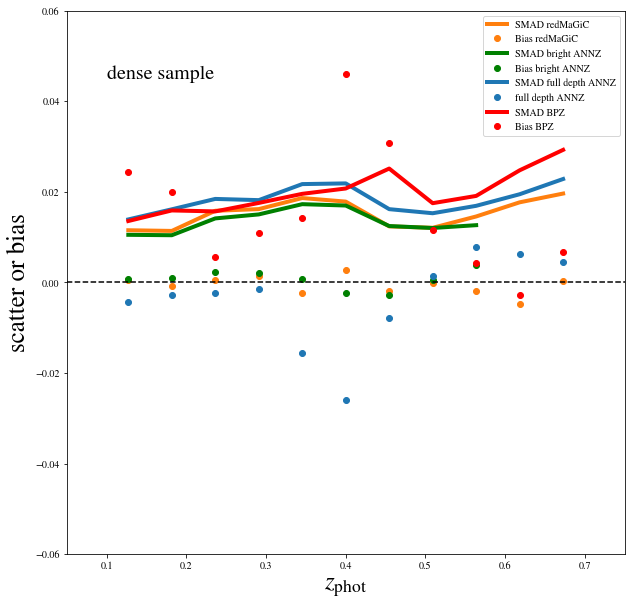

In [115]:
red_bias_scatter_dense()

In [79]:
def red_bias_scatter_lum():
    plt.figure(figsize = (10,10))
    nbins = 10
    bins = np.linspace(0.11 , 0.7 , nbins)
    delta = bins[1]-bins[0]
    
    
    
    mask_one = np.where((np.in1d(ID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    
    ID_lum_copy = ID_lum[mask_one][arg_one]
    z_spec_matched_to_lum = z_specall[mask_two][arg_two]
    
    
    y2 = (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    x2 = z_lum[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)


    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))
    plt.figure(figsize = (10,10))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = '#FF7F0E',  label = "SMAD redMaGiC")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = '#FF7F0E', 
             label = "Bias redMaGiC")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    out_mask =  (z_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    #######################################################################################################
    
    nbins = 8
    bins = np.linspace(0.11 , 0.69 , nbins)
    delta = bins[1]-bins[0]
    mask_one = np.where((np.in1d(bright_z_ID, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,bright_z_ID[mask_one])==True))[0]
    arg_one = np.argsort(bright_z_ID[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    y2 = (bright_z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])
    z2 = bright_z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = bright_z_ann[mask_one][arg_one]
    print bright_z_ann[mask_one][arg_one].max()
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12)[:-2])

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = 'g',  label = "SMAD bright ANNZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12)[:-2])

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = 'g', 
             label = "Bias bright ANNZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    out_mask =  (bright_z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    #plt.plot(bins , running_sigma682 , lw= 4, color = '#1F77B4', label = r"$\sigma_{68}/(1+z)$")
    
    #######################################################################################################
    mask_one = np.where((np.in1d(ID_kids, ID_lum_copy)==True))[0]
    mask_two = np.where((np.in1d(ID_lum_copy,ID_kids[mask_one])==True))[0]
    arg_one = np.argsort(ID_kids[mask_one])
    arg_two = np.argsort(ID_lum_copy[mask_two])
    
    y2 = (z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])
    z2 = z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = z_ann[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    running_sigma682 = [np.percentile(y2[idx2==k], 68) for k in range(nbins)]
    running_mad2 = [median_absolute_deviation(y2[idx2==k]) for k in range(nbins)]
    running_bias2 = [np.median(z2[idx2==k]) for k in range(nbins)]
    
    out_mask =  (z_ann[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color =  '#1F77B4',  label = "SMAD full depth ANNZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color =  '#1F77B4', 
             label = "full depth ANNZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    
    y2 = (z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])
    z2 = z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two]
    x2 = z_bpz[mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    
    
    

    
    
    out_mask =  (z_bpz[mask_one][arg_one] - z_spec_matched_to_lum[mask_two][arg_two])/(1+z_spec_matched_to_lum[mask_two][arg_two])>0.08
    print "5sigma outlier fraction" , np.where(out_mask==True)[0].shape[0]*1.0*100/out_mask.shape[0]
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4, color = 'r',  label = "SMAD BPZ")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=np.linspace(0.1,0.7,12))

    plt.plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , lw = 0, marker = "o", color = 'r', 
             label = "Bias BPZ")
    
    print "mean bias" , np.mean(np.abs(bin_means))
    print "mean scatter" , 1.4826*np.mean(bin_std)
    
    
    plt.plot(np.linspace(0.0,1.0,200) , 0.0*np.linspace(0.1,0.8,200), "k--")
    plt.xlabel(r"$z_{phot}$" , fontsize= 25)
    plt.ylabel("scatter or bias" , fontsize= 25)
    plt.legend(loc = 'best' , fontsize = 10)
    plt.xlim([0.05,0.75])
    plt.ylim([-0.06,0.06])
    plt.text( 0.1, 0.045, "luminous sample", fontsize = 20)

    
    return None

mean bias 0.0018029114616651182
mean scatter 0.014786057294782565
5sigma outlier fraction 0.155424308362
0.625338614
mean bias 0.0014879496539969453
mean scatter 0.013145809603543258
5sigma outlier fraction 0.12323702588
5sigma outlier fraction 0.310848616724
mean bias 0.01022833992871864
mean scatter 0.0163533586894205
5sigma outlier fraction 0.559527510103
mean bias 0.018209134313193234
mean scatter 0.018808090057500074


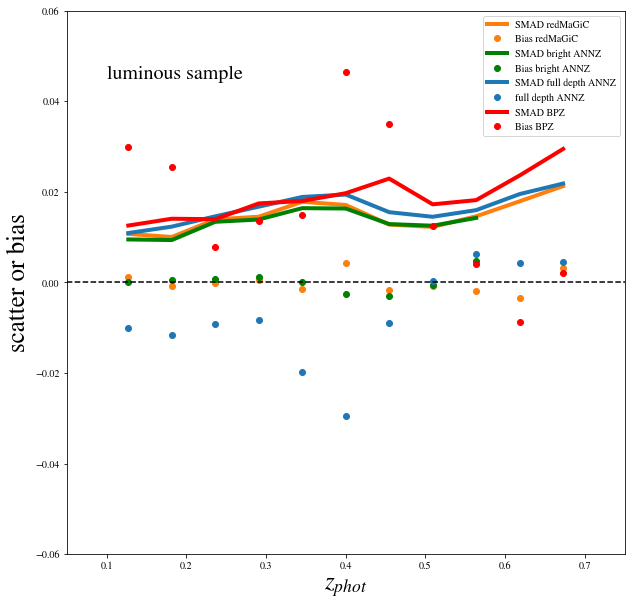

In [80]:
red_bias_scatter_lum()

In [99]:
levels = [0.68, 0.95]
def lum_color_inspec():
    
    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_lum#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    for i in range (1,12):
        
       mask_all = (z_lum[mask_one][arg_one] <0.12+i*0.05)&(z_lum[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_lum<0.12+i*0.05)&(z_lum>0.1+i*0.05)
       
       #plt.text(str(0.1+i*0.05)+","+str(0.12+i*0.05))
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample")
       
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

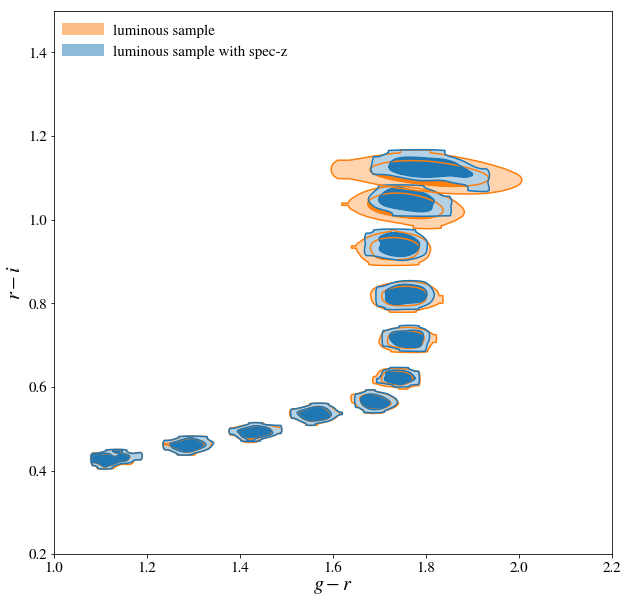

In [100]:
lum_color_inspec()

In [101]:
levels = [0.68, 0.95]
def lum_color_inspec2():
    
    mask_one = np.where((np.in1d(ID_lum, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_lum[mask_one])==True))[0]
    arg_one = np.argsort(ID_lum[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_lum#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="luminous sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="luminous sample")
    for i in range (1,12):
        
       mask_all = (z_lum[mask_one][arg_one] <0.12+i*0.05)&(z_lum[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_lum<0.12+i*0.05)&(z_lum>0.1+i*0.05)&(mi_lum<np.max(mi_specall[mask_two][arg_two][mask_all]))
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


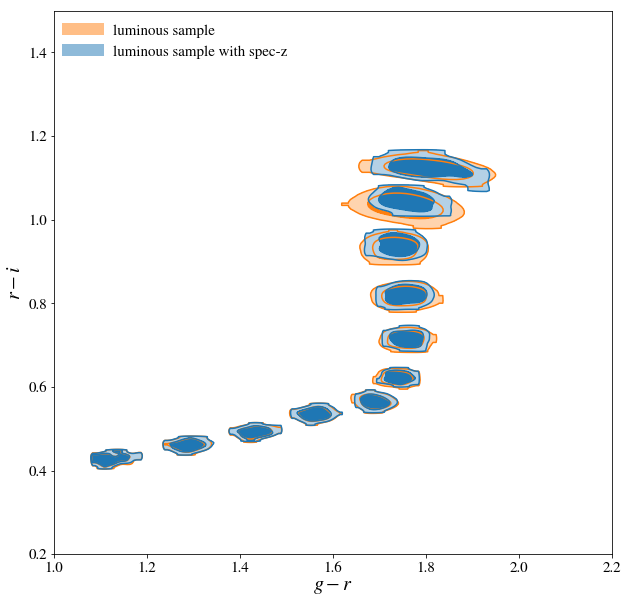

In [102]:
lum_color_inspec2()

In [85]:
levels = [0.68, 0.95]
def dense_color_inspec():
    
    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_dense#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample")
    for i in range (1,12):
        
       mask_all = (z_dense[mask_one][arg_one] <0.12+i*0.05)&(z_dense[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_dense<0.12+i*0.05)&(z_dense>0.1+i*0.05)
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


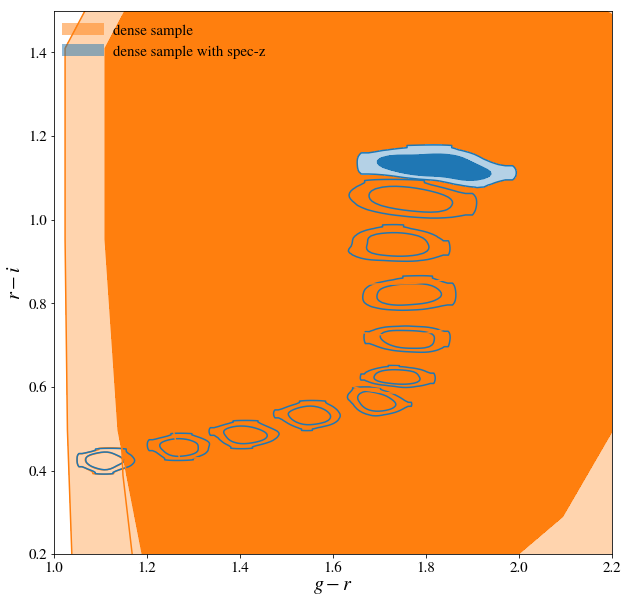

In [86]:
dense_color_inspec()

In [103]:
levels = [0.68, 0.95]
def dense_color_inspec2():
    
    mask_one = np.where((np.in1d(ID_dense, ID_spec)==True))[0]
    mask_two = np.where((np.in1d(ID_spec,ID_dense[mask_one])==True))[0]
    arg_one = np.argsort(ID_dense[mask_one])
    arg_two = np.argsort(ID_spec[mask_two])
    
    x = colors_dense#[mask_one][arg_one]
    y = colors_spec[mask_two][arg_two]
    
    plt.figure(figsize=(10,10))
    
    thick_line1 = mlines.Line2D([], [], ls='-', c='#1F77B4', linewidth=12, alpha=0.5, 
                                label="dense sample with spec-z")
    thick_line2 = mlines.Line2D([], [], ls='-', c='#FF7F0E', linewidth=12, alpha=0.5, 
                                label="dense sample")
    for i in range (1,12):
        
       mask_all = (z_dense[mask_one][arg_one] <0.12+i*0.05)&(z_dense[mask_one][arg_one] >0.1+i*0.05)
       mask_lum = (z_dense<0.12+i*0.05)&(z_dense>0.1+i*0.05)&(mi_dense<np.max(mi_spec[mask_two][arg_two][mask_all]))
       
       print 0.11+i*0.05
       corner.hist2d(x[mask_lum,1] , x[mask_lum,2], color='#FF7F0E', plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample with spec-z")
       corner.hist2d(y[mask_all,1] , y[mask_all,2], color='#1F77B4',plot_datapoints=False,
                 bins=20, levels=levels, fill_contours=True, smooth=2.0, label = "luminous sample")
    
    plt.legend(loc='upper left', handles=[thick_line2, thick_line1], 
               frameon=False, fontsize=15, handletextpad=1.0, scatteryoffsets=[0.5])
    plt.xlim((1,2.2))
    plt.ylim(0.2,1.5)
    plt.xlabel("$g-r$" , fontsize = 20)
    plt.ylabel("$r-i$" , fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    return None

0.16
0.21
0.26
0.31
0.36
0.41
0.46
0.51
0.56
0.61
0.66


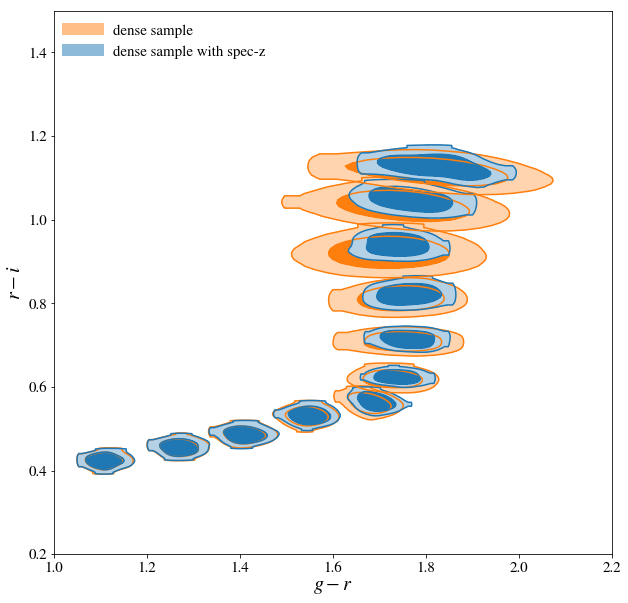

In [104]:
dense_color_inspec2()

In [73]:
import pandas as pd
df=pd.read_csv("KiDS_DR3_tile_table.csv", sep=',')

In [74]:
mask = df.values[:,3] == 'g'
gtiles = df.values[mask]
mask = df.values[:,3] == 'r'
rtiles = df.values[mask]
mask = df.values[:,3] == 'i'
itiles = df.values[mask]

In [75]:
print "RA and DEC range of each tile is 62.3 × 66.8 arcminutes"

RA and DEC range of each tile is 62.3 × 66.8 arcminutes


In [76]:
df

,'ID',RA,DEC,BAND,DATA,FWHM,ELL,MAG_LIM,COMP,GAIN,GRADE
0,KIDS_43.7_-30.2,43.706,-30.170,g,2014-12-21 03:51:18,1.10,0.03,25.28,24.04,1.714885e+13,B
1,KIDS_52.3_-33.1,52.277,-33.137,r,2012-11-18 05:56:55,0.71,0.05,25.00,23.99,2.901113e+13,C
2,KIDS_332.0_-31.2,332.039,-31.159,u,2014-10-24 01:08:59,1.05,0.04,24.10,22.95,3.208289e+12,B
3,KIDS_45.1_-33.1,45.149,-33.137,u,2012-11-08 05:28:19,0.99,0.03,24.21,23.05,3.413183e+12,B
4,KIDS_218.0_-0.5,218.000,-0.500,g,2015-04-14 06:55:15,1.01,0.06,24.87,23.73,1.599688e+13,A
5,KIDS_344.9_-31.2,344.854,-31.159,i,2011-11-10 03:04:29,1.05,0.04,23.41,22.17,1.341007e+13,B
6,KIDS_217.0_1.5,217.000,1.489,g,2015-05-13 05:35:02,0.69,0.05,24.99,23.98,1.561299e+13,A
7,KIDS_218.0_-0.5,218.000,-0.500,i,2013-03-24 06:11:03,0.62,0.06,23.84,23.01,1.348851e+13,B
8,KIDS_180.5_-2.5,180.501,-2.478,g,2014-04-19 00:44:59,0.90,0.04,25.11,24.00,1.705474e+13,B
9,KIDS_173.0_-0.5,173.000,-0.500,r,2013-04-09 04:18:26,0.61,0.05,24.89,23.97,3.168680e+13,A


In [96]:
def value_added_coordinate(ra , dec):
    
    mask_r = (ra>rtiles[:,1]-62.3/120)&(ra<rtiles[:,1]+62.3/120)&(dec>rtiles[:,2]-66.8/120)&(dec<rtiles[:,2]+66.8/120)
    fwhm_r , maglim_r , comp_r = rtiles[mask_r,5] , rtiles[mask_r,7], rtiles[mask_r,8]
    if len(mask_r[mask_r==True])<1:
        fwhm_r, maglim_r, comp_r = 1000, 1000, 1000
    
    mask_g=(ra>gtiles[:,1]-62.3/120)&(ra<gtiles[:,1]+62.3/120)&(dec>gtiles[:,2]-66.8/120)&(dec<gtiles[:,2]+66.8/120)
    fwhm_g , maglim_g , comp_g = gtiles[mask_g,5] , gtiles[mask_g,7], gtiles[mask_g,8]
    if len(mask_g[mask_g==True])<1:
        fwhm_g, maglim_g, comp_g = 1000, 1000, 1000
    
    mask_i=(ra>itiles[:,1]-62.3/120)&(ra<itiles[:,1]+62.3/120)&(dec>itiles[:,2]-66.8/120)&(dec<itiles[:,2]+66.8/120)
    fwhm_i , maglim_i , comp_i = itiles[mask_i,5] , itiles[mask_i,7], itiles[mask_i,8]
    if len(mask_i[mask_i==True])<1:
        fwhm_i, maglim_i, comp_i = 1000, 1000, 1000
    
    return np.array([np.mean(fwhm_g) , np.mean(fwhm_r), np.mean(fwhm_i) \
           , np.mean(maglim_g), np.mean(maglim_r), np.mean(maglim_i) \
           , np.mean(comp_g), np.mean(comp_r), np.mean(comp_i)])   

In [97]:
mask_one = np.where((np.in1d(ID_kids , ID_lum)==True))[0]
mask_two = np.where((np.in1d(ID_lum  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_lum[mask_two])
kRA_lum = RA[mask_one][arg_one]
kDEC_lum = DEC[mask_one][arg_one]
kID_lum = ID_lum[mask_two][arg_two]
kz_lum = z_lum[mask_two][arg_two]

In [98]:
mask_one = np.where((np.in1d(ID_kids , ID_dense)==True))[0]
mask_two = np.where((np.in1d(ID_dense  , ID_kids[mask_one])==True))[0]
    
arg_one = np.argsort(ID_kids[mask_one])
arg_two = np.argsort(ID_dense[mask_two])
kRA_dense = RA[mask_one][arg_one]
kDEC_dense = DEC[mask_one][arg_one]
kID_dense = ID_dense[mask_two][arg_two]
kz_dense = z_dense[mask_two][arg_two]

In [99]:
def value_added_dense():
    
    values = []
    for i in range(len(kz_dense)):
        values.append(value_added_coordinate(kRA_dense[i], kDEC_dense[i]))
        
    return np.array(values)

def value_added_lum():
    
    values = []
    for i in range(len(kz_lum)):
        values.append(value_added_coordinate(kRA_lum[i], kDEC_lum[i]))
        
    return np.array(values)

In [100]:
sys_lum = value_added_lum()

In [101]:
sys_dense = value_added_dense()

In [102]:
kz_dense = kz_dense[sys_dense[:,0]<1000.]
kID_dense = kID_dense[sys_dense[:,0]<1000.]
sys_dense = sys_dense[sys_dense[:,0]<1000.]

In [103]:
kz_lum = kz_lum[sys_lum[:,0]<1000.]
kID_lum = kID_lum[sys_lum[:,0]<1000.]
sys_lum = sys_lum[sys_lum[:,0]<1000.]

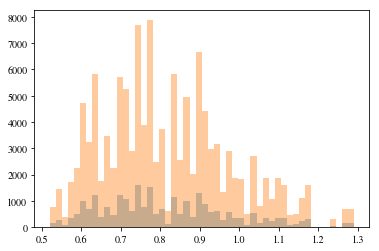

In [104]:
sns.distplot(sys_lum[:,2], kde = False, norm_hist=False)
sns.distplot(sys_dense[:,2], kde= False, norm_hist=False)

In [107]:
def bias_dense_FWHM():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_dense[mask_one])==True))[0]
    arg_one = np.argsort(kID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## FWHM g ###############
    
    nbins = 10
    bins = np.linspace(0.55 , 1.25 , nbins)
    delta = bins[1]-bins[0]
    x2 = sys_dense[:,0][mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    bins = np.linspace(x2.min() , x2.max() , nbins)

   
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    #ax[0].plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    #ax[0].plot(bins , running_bias2 , lw = 1, marker = "o", label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)


    ax[0,0].set_ylim([-0.015,0.025])
    
    sns.distplot(np.array(gtiles[:,5] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins = bins)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    ########## FWHM r ###############
    
    nbins = 10
    bins = np.linspace(0.55 , 1. , nbins)
    delta = bins[1]-bins[0]
    x2 = sys_dense[:,1][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max() , nbins)

    idx2  = np.digitize(x2,bins)

   
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    #ax[0].plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    #ax[0].plot(bins , running_bias2 , lw = 1, marker = "o", label = "Bias")
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,1].set_xlabel(r"$r\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)

    ax[0,1].set_ylim([-0.015,0.025])
    
    sns.distplot(np.array(rtiles[:,5] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = bins)

    ########## FWHM i ###############
    
    nbins = 10
    bins = np.linspace(0.57 , 1.3 , nbins)
    delta = bins[1]-bins[0]
    x2 = sys_dense[:,2][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max() , nbins)

    
    idx2  = np.digitize(x2,bins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,2].set_xlabel(r"$i\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)
    ax[0,2].set_ylim([-0.015,0.025])
    sns.distplot(np.array(itiles[:,5] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = bins)
    
    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_psf_dense.png")
    return None

def bias_lum_FWHM():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_lum[mask_one])==True))[0]
    arg_one = np.argsort(kID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## FWHM g ###############
    
    nbins = 10
    bins = np.linspace(0.55 , 1.25 , nbins)
    delta = bins[1]-bins[0]
    x2 = sys_lum[:,0][mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    bins = np.linspace(x2.min() , x2.max() , nbins)

   
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    #ax[0].plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    #ax[0].plot(bins , running_bias2 , lw = 1, marker = "o", label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)


    ax[0,0].set_ylim([-0.015,0.025])
    
    sns.distplot(np.array(gtiles[:,5] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins = bins)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    ########## FWHM r ###############
    
    nbins = 10
    bins = np.linspace(0.55 , 1. , nbins)

    
    delta = bins[1]-bins[0]
    x2 = sys_lum[:,1][mask_one][arg_one]
    idx2  = np.digitize(x2,bins)
    bins = np.linspace(x2.min() , x2.max() , nbins)

   
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    #ax[0].plot(bins , 1.4826*np.array(running_mad2) , lw = 4, label = "SMAD")
    #ax[0].plot(bins , running_bias2 , lw = 1, marker = "o", label = "Bias")
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,1].set_xlabel(r"$r\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)

    ax[0,1].set_ylim([-0.015,0.025])
    
    sns.distplot(np.array(rtiles[:,5] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = bins)

    ########## FWHM i ###############
    
    nbins = 10
    bins = np.linspace(0.57 , 1.3 , nbins)

    delta = bins[1]-bins[0]
    x2 = sys_lum[:,2][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max() , nbins)

    idx2  = np.digitize(x2,bins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")

    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,2].set_xlabel(r"$i\;\mathrm{PSF \; FWHM} \; \;(\mathrm{arcsec}) $" , fontsize= 15)
    ax[0,2].set_ylim([-0.015,0.025])
    sns.distplot(np.array(itiles[:,5] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = bins)
    
    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_psf_lum.png")
    return None


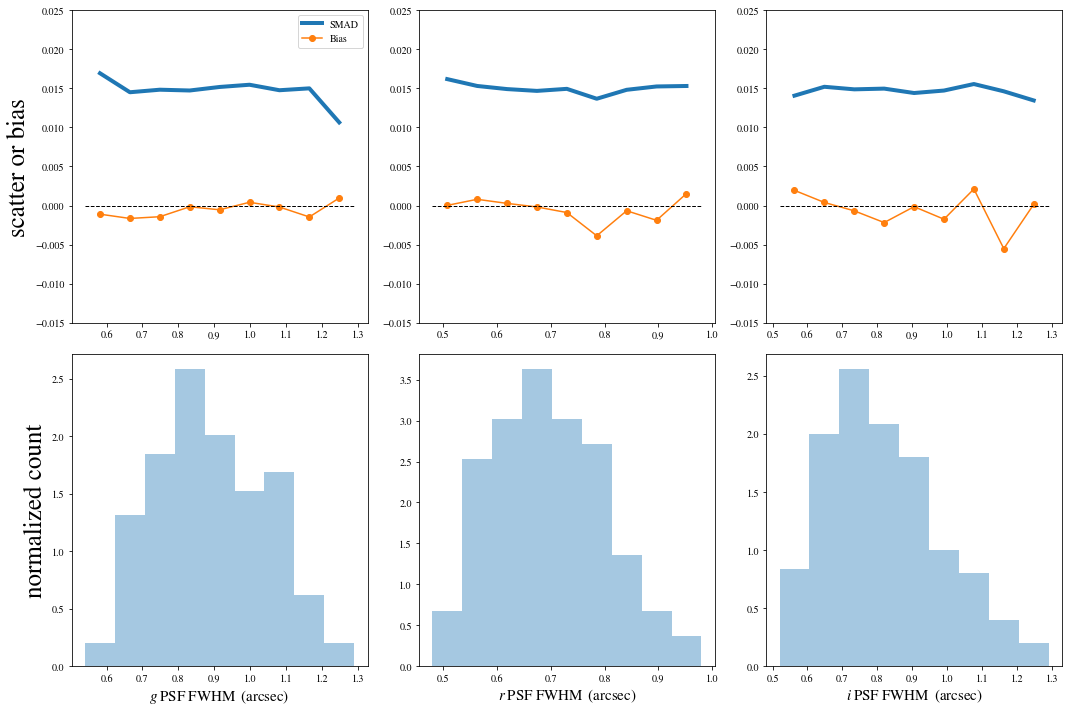

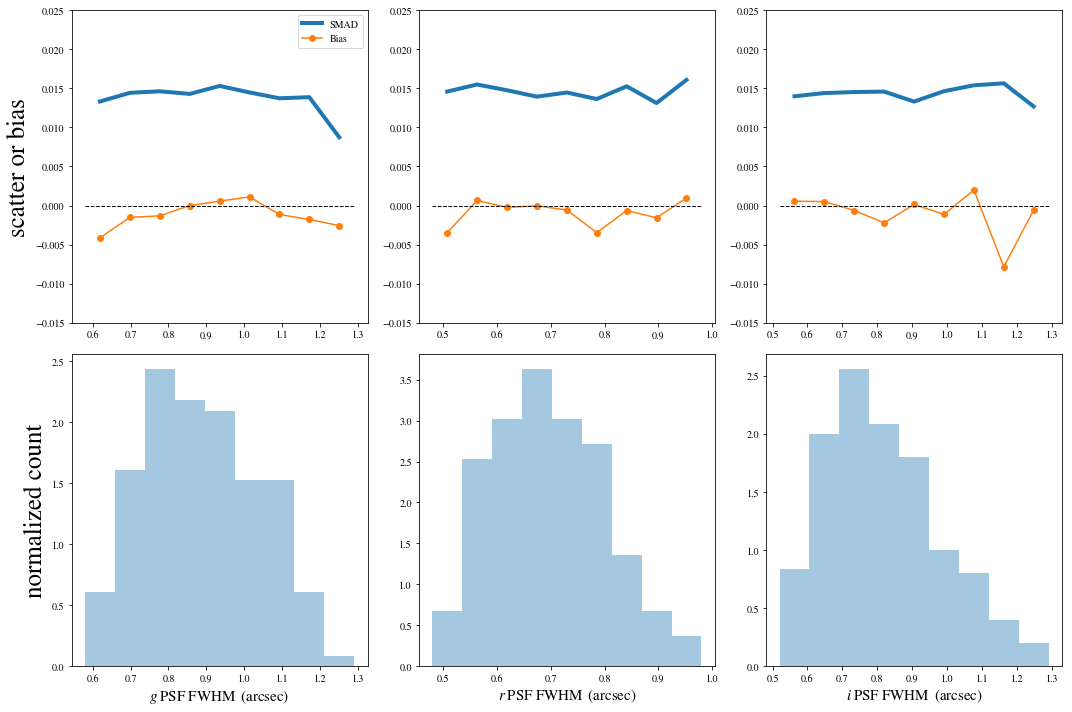

In [108]:
bias_dense_FWHM()
bias_lum_FWHM()

In [109]:
def bias_dense_maglim():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_dense[mask_one])==True))[0]
    arg_one = np.argsort(kID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## maglim g ###############
    
    
    nbins = 10
    x2 = sys_dense[:,3][mask_one][arg_one]
    bins = np.linspace(24.6 , x2.max(), nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{mag \; lim}$" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)
    ax[0,0].set_ylim([-0.01,0.02])
    ax[0,0].set_ylim([-0.015,.025])

    sns.distplot(np.array(gtiles[:,7] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins = bins)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    #ax[1,0].histogram(gtiles[:,7], bins =5)

    ########## maglim r ###############
    
        
    nbins = 10
    x2 = sys_dense[:,4][mask_one][arg_one]
    #ins = np.linspace(24.7 , 25.1, nbins)
    bins = np.linspace( 24.7 , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)

    ax[1,1].set_xlabel(r"$r\;\mathrm{mag \; lim}$" , fontsize= 15)
    ax[0,1].set_ylim([-0.01,0.02])
    ax[0,1].set_ylim([-0.015,.025])

    sns.distplot(np.array(rtiles[:,7] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = bins)

    ########## maglim i ###############
       
    nbins = 10
    x2 = sys_dense[:,5][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max(), nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[0,2].set_ylim([-0.01,0.02])
    ax[0,2].set_ylim([-0.015,.025])

    ax[1,2].set_xlabel(r"$i\;\mathrm{mag \; lim}$" , fontsize= 15)
    sns.distplot(np.array(itiles[:,7] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = bins)
    

    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_maglim.png")

    return None

def bias_lum_maglim():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_lum[mask_one])==True))[0]
    arg_one = np.argsort(kID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## maglim g ###############
    
    
    nbins = 10
    x2 = sys_lum[:,3][mask_one][arg_one]
    bins = np.linspace(24.6 , x2.max(), nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)


    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{mag \; lim}$" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)
    ax[0,0].set_ylim([-0.01,0.02])
    ax[0,0].set_ylim([-0.015,.025])

    sns.distplot(np.array(gtiles[:,7] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins = bins)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    #ax[1,0].histogram(gtiles[:,7], bins =5)

    ########## maglim r ###############
    
        
    nbins = 10
    x2 = sys_lum[:,4][mask_one][arg_one]
    #ins = np.linspace(24.7 , 25.1, nbins)
    bins = np.linspace(24.7, x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)

    ax[1,1].set_xlabel(r"$r\;\mathrm{mag \; lim}$" , fontsize= 15)
    ax[0,1].set_ylim([-0.01,0.02])
    ax[0,1].set_ylim([-0.015,.025])

    sns.distplot(np.array(rtiles[:,7] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = bins)

    ########## maglim i ###############
       
    nbins = 10
    x2 = sys_lum[:,5][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max(), nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[0,2].set_ylim([-0.015,.025])

    ax[1,2].set_xlabel(r"$i\;\mathrm{mag \; lim}$" , fontsize= 15)
    sns.distplot(np.array(itiles[:,7] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = bins)
    

    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_maglim.png")

    return None


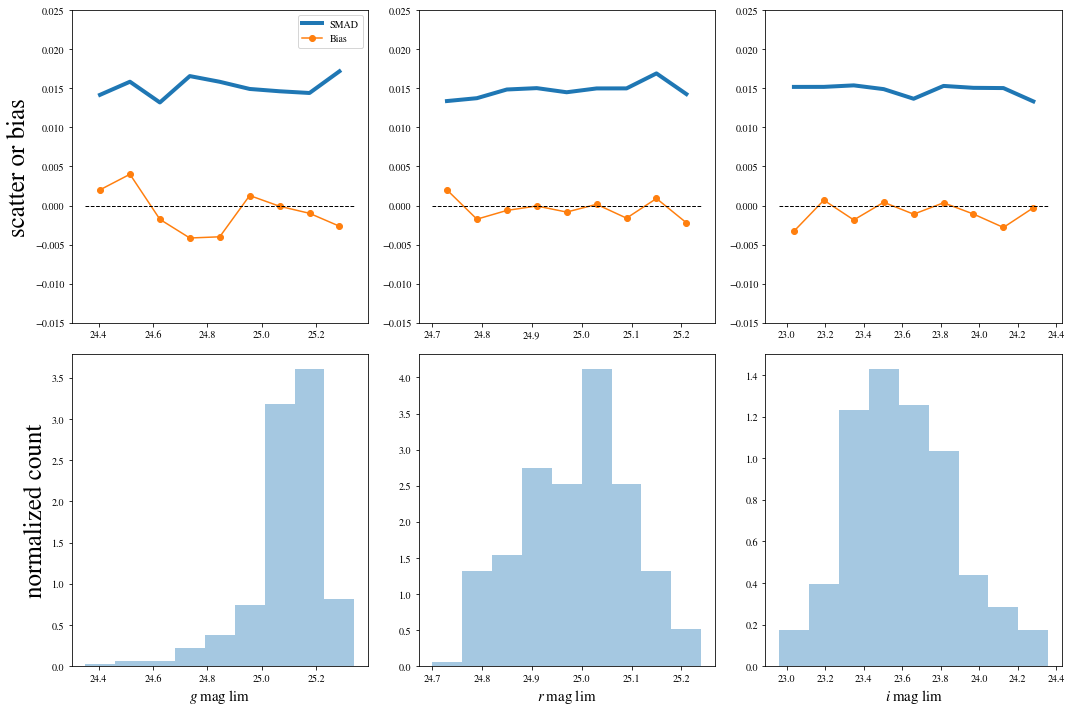

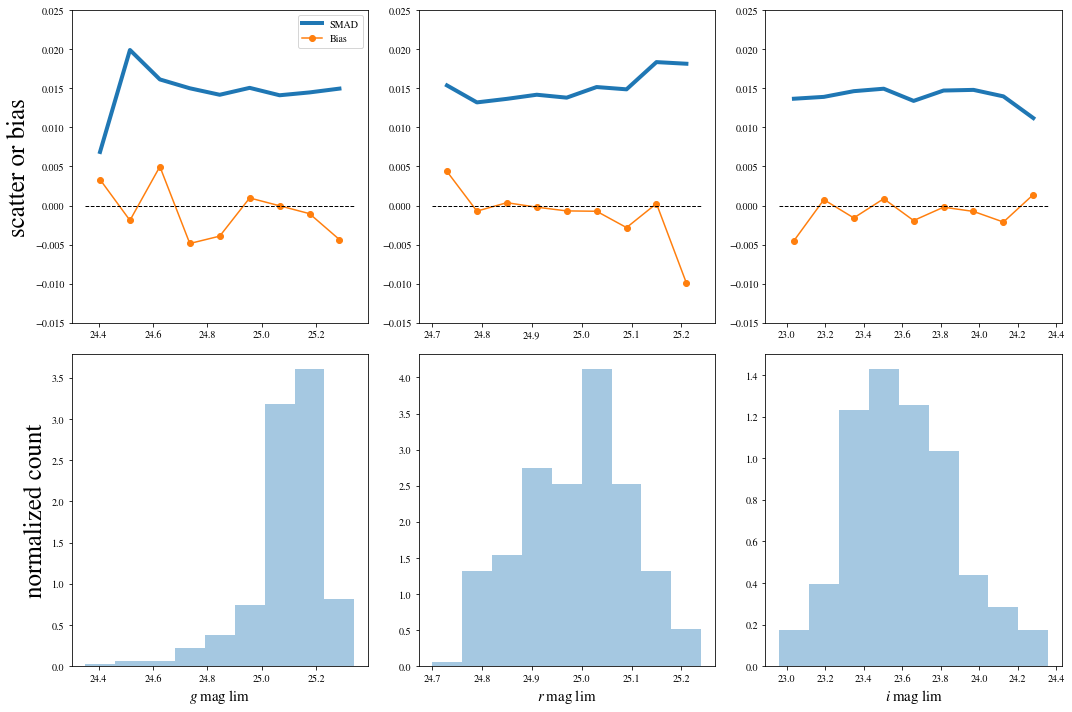

In [110]:
bias_dense_maglim()
bias_lum_maglim()

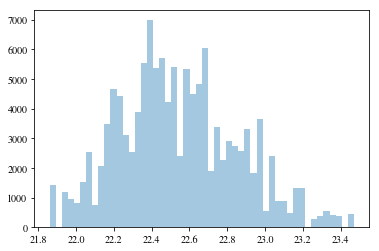

In [111]:
sns.distplot(sys_dense[:,8], kde=False)

In [112]:
def bias_dense_comp():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_dense, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_dense[mask_one])==True))[0]
    arg_one = np.argsort(kID_dense[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_dense[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## maglim g ###############
    
    
    nbins = 10
    x2 = sys_dense[:,6][mask_one][arg_one]
    bins = np.linspace(x2.min() , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)
    ax[0,0].set_ylim([-0.015,0.025])

    sns.distplot(np.array(gtiles[:,8] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins =12)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    #ax[1,0].histogram(gtiles[:,7], bins =5)

    ########## maglim r ###############
    
        
    nbins = 10
    x2 = sys_dense[:,7][mask_one][arg_one]
    bins = np.linspace(23.6, 24.35, nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)

    ax[1,1].set_xlabel(r"$r\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    ax[0,1].set_ylim([-0.015,0.025])
    sns.distplot(np.array(rtiles[:,8] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = 12)

    ########## maglim i ###############
       
    nbins = 10
    x2 = sys_dense[:,8][mask_one][arg_one]
    bins = np.linspace(21.9 , 23.4, nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[0,2].set_ylim([-0.015,0.025])

    ax[1,2].set_xlabel(r"$i\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    sns.distplot(np.array(itiles[:,8] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = 12)
    

    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_comp_dense.png")

    return None

def bias_lum_comp():
    
    fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10))
    
    mask_one = np.where((np.in1d(kID_lum, ID_specall)==True))[0]
    mask_two = np.where((np.in1d(ID_specall,kID_lum[mask_one])==True))[0]
    arg_one = np.argsort(kID_lum[mask_one])
    arg_two = np.argsort(ID_specall[mask_two])
    y2 = (kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two])/(1+z_specall[mask_two][arg_two])
    z2 = kz_lum[mask_one][arg_one] - z_specall[mask_two][arg_two]
    
    ########## maglim g ###############
    
    
    nbins = 10
    x2 = sys_lum[:,6][mask_one][arg_one]
    bins = np.linspace(23.4 , 24.35, nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,0].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    ax[0,0].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[1,0].set_xlabel(r"$g\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    ax[0,0].set_ylabel("scatter or bias" , fontsize= 25)
    ax[0,0].legend(loc = 'best' , fontsize = 10)
    ax[0,0].set_ylim([-0.015,0.025])

    sns.distplot(np.array(gtiles[:,8] , dtype=float), kde = False, ax= ax[1,0], 
                 norm_hist = True, bins =12)
    ax[1,0].set_ylabel("normalized count", fontsize= 25)

    #ax[1,0].histogram(gtiles[:,7], bins =5)

    ########## maglim r ###############
    
        
    nbins = 10
    x2 = sys_lum[:,7][mask_one][arg_one]
    bins = np.linspace(23.6, 24.35, nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)
    
    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,1].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,1].plot(bins, bins*0.0 , "k--", lw = 1)

    ax[1,1].set_xlabel(r"$r\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    ax[0,1].set_ylim([-0.015,0.025])
    sns.distplot(np.array(rtiles[:,8] , dtype=float), kde = False, ax= ax[1,1], 
                 norm_hist = True, bins = 12)

    ########## maglim i ###############
       
    nbins = 10
    x2 = sys_lum[:,8][mask_one][arg_one]
    bins = np.linspace(21.9 , 23.4, nbins)
    bins = np.linspace(x2.min() , x2.max(), nbins)

    bin_std, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             y2, 
                                                             statistic=median_absolute_deviation, 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , 1.4826*bin_std , lw = 4,  label = "SMAD")

    bin_means, bin_edges, binnumber = stats.binned_statistic(x2, 
                                                             z2, 
                                                             statistic='median', 
                                                             bins=bins)

    ax[0,2].plot(.5*(bin_edges[1:]+bin_edges[:-1]) , bin_means , marker = "o", 
             label = "Bias")
    
    ax[0,2].plot(bins, bins*0.0 , "k--", lw = 1)
    ax[0,2].set_ylim([-0.015,0.025])

    ax[1,2].set_xlabel(r"$i\;\mathrm{98\% \; completeness \; mag}$" , fontsize= 15)
    sns.distplot(np.array(itiles[:,8] , dtype=float), kde = False, ax= ax[1,2], 
                 norm_hist = True, bins = 12)
    

    plt.tight_layout()
    plt.savefig("/home/vakili/public_html/systematics/error_comp_lum.png")

    return None


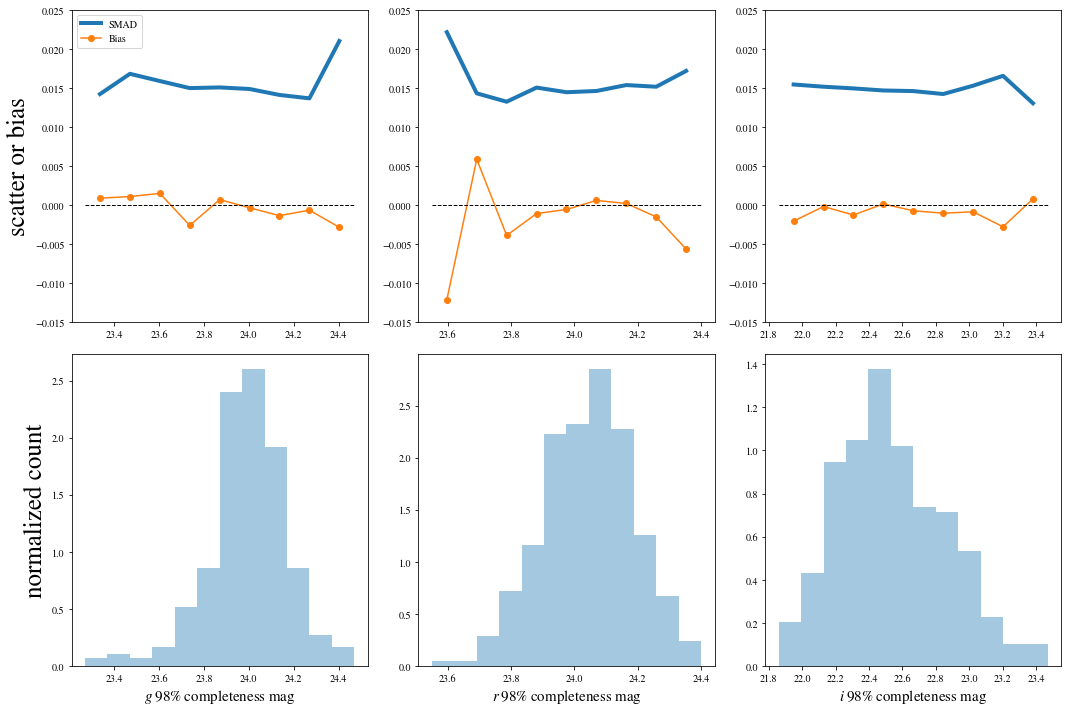

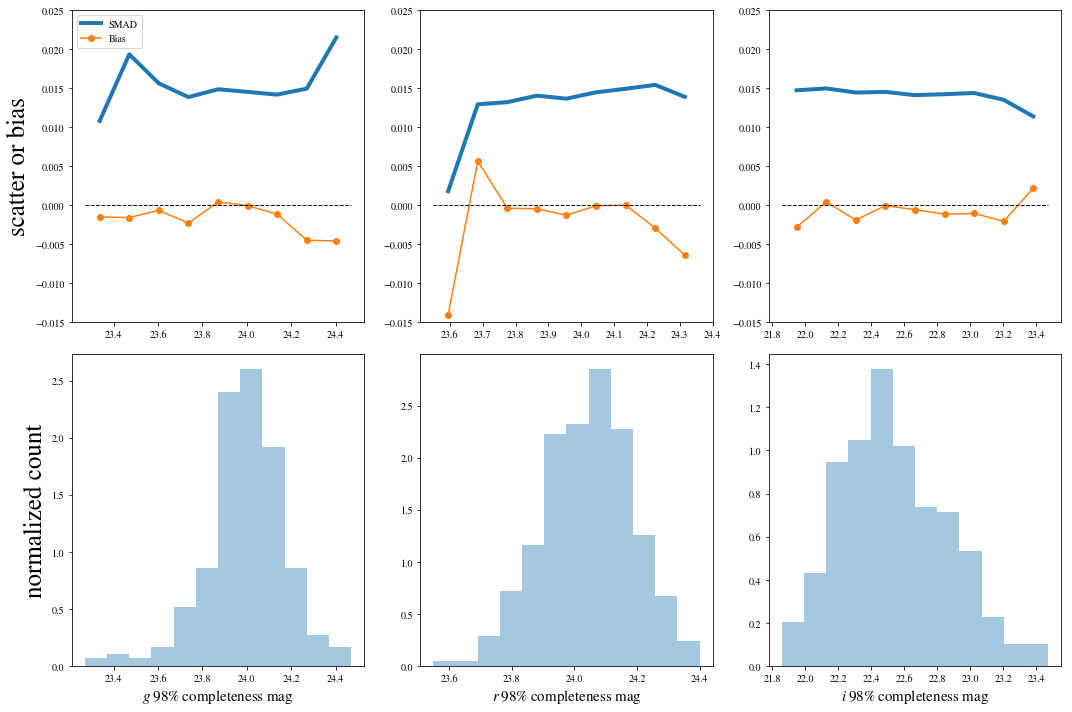

In [113]:
bias_dense_comp()
bias_lum_comp()

In [93]:
(z_dense.shape[0] - 18)/40.

4793.925

In [94]:
(z_lum.shape[0]-31)/40.

966.0

In [95]:
def f(x):
    
    a = x**2
    
    for i ... 
        jhsjdhsj
    return a

SyntaxError: invalid syntax (<ipython-input-95-e1acac1e17a3>, line 5)

In [ ]:
for i in range(10):
    print i    

In [ ]:


for i in range(1,10):
    x = []    
    x.append(i)

In [ ]:
x

In [ ]:
def f(a,b):
    
    return a, b

In [ ]:
f(10,2)

In [ ]:
np.remainder(np.arange(7), 5)

In [ ]:
np.remainder(7,5)